# Notebook 3: Analysis (1) => TIME SERIES analysis, modeling, forecasting and comparison with Madrid Central reality

In [1]:
import pandas as pd
import numpy as np
import calendar
import datetime
import folium
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# Loading the csv previously created with all the traffic information from 2015-01 to 2019-04 of all the devices..
# ..chosen for the analysis

final_data = pd.read_csv('final_data.csv', sep = ';')

## First part of the analysis:
### I will split the data in before and after Madrid Central implementation. The objective is by a time series analysis, predict how was going to be the evolution of the traffic intensity without Madrid Central and compare vs what really happened with Madrid Central running.


In [3]:
# Split the dataset in 2 parts:
# One with all the observations until the implementation of Madrid Central
# Another one with only observations since Madrid Central was launched

data_before_MC = final_data[final_data['Madrid-Central'] == 0]
data_only_MC = final_data[final_data['Madrid-Central'] == 1]

In [4]:
pd.options.display.max_columns = None

### Before continue, quick remind about the devices the analysis will be focus on: the idea is to analyze the impact on the main streets around Madrid Central and also in Gran Via. I will select one of each pair.

#### AROUND MADRID-CENTRAL:
    4353: Princesa South-North (SN)
    4354: Princesa North-South (NS) (this one)

    4265: Gran Via de San Francisco el Grande South-North (SN)
    3478: Gran Via de San Francisco el Grande North-South (NS) (this one)

    4211: Ronda de Valencia West-East (WE) (this one)
    5104: Ronda de Valencia East-West (EW)

    4386: Alberto Aguilera West-East (WE) (this one)
    4384: Alberto Aguilera East-West (EW)

    3848: Genova East-West (EW)
    3850: Genova West-East (WE) (this one)

    7138: Paseo del Prado South-North (SN)
    7139: Paseo del Prado North-South (NS) (this one)

#### GRAN VIA
    4301: Gran Via North-South (NS)
    4305: Gran Via South-North (SN) (this one)
    

### A Time Series follows the next steps:

<img src='Time Series chart.png'>

#### In the analysis we will follow all the steps mentioned above for the devices selected. Let's see what is the result of these new initiative of traffic restriction to the center of Madrid!

### Focus on GENOVA West-East

In [5]:
# Split the information of each devices in:
    # Full dataset
    # Observations before Madrid Central (with the suffix "before_MC")
    # Observations since the beginning of Madrid Central (with the suffix "only_MC")

genova_WE = final_data[final_data['id'] == 3850]
genova_WE_before_MC = data_before_MC[data_before_MC['id'] == 3850]
genova_WE_only_MC = data_only_MC[data_only_MC['id'] == 3850]

In [6]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

genova_WE_before_MC = genova_WE_before_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
genova_WE_before_MC = genova_WE_before_MC.set_index(genova_WE_before_MC['Año_mes'])
genova_WE_before_MC.index = pd.to_datetime(genova_WE_before_MC.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_genova_WE_before_MC = genova_WE_before_MC['intensidad'].resample('M').mean()

In [7]:
series_genova_WE_before_MC.head()

Año_mes
2015-01-31    1252.436652
2015-02-28    1254.664879
2015-03-31    1233.252025
2015-04-30    1192.848871
2015-05-31    1211.651297
Freq: M, Name: intensidad, dtype: float64

Text(0.5, 1.0, 'Time Series Genova West-East')

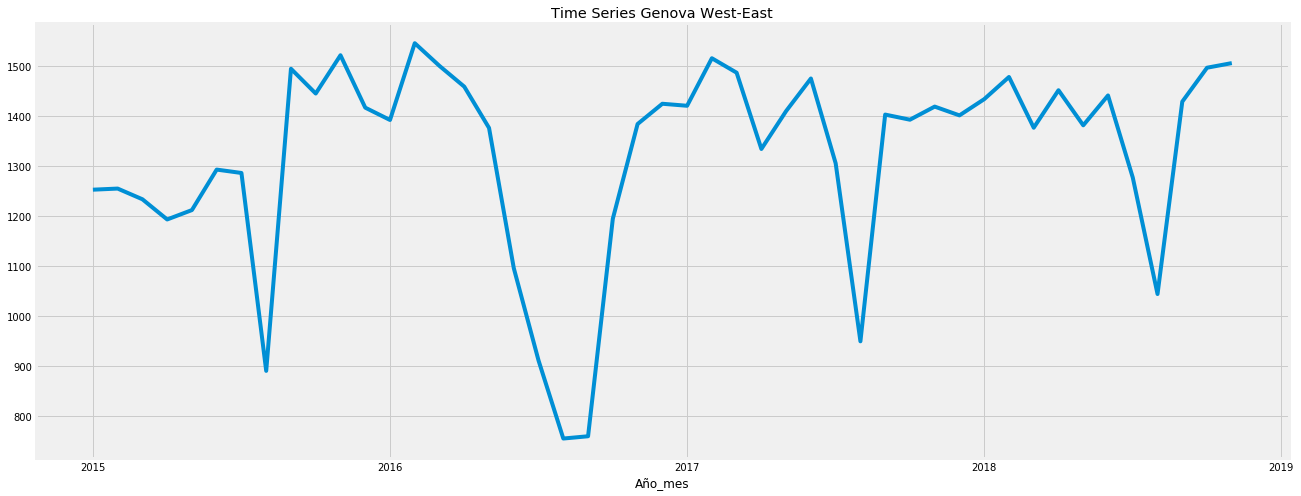

In [8]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_genova_WE_before_MC.plot()
plt.title('Time Series Genova West-East')

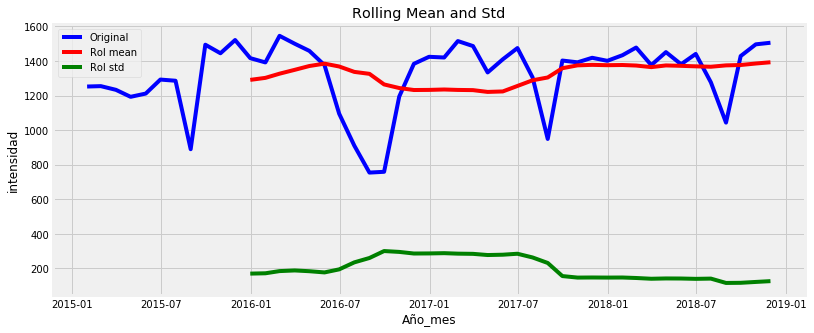

In [9]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_genova_WE = series_genova_WE_before_MC.rolling(12).mean()
rolstd_genova_WE = series_genova_WE_before_MC.rolling(12).std()

plt.figure(figsize=(12,5))
plt.plot(series_genova_WE_before_MC, label = 'Original', color = 'blue')
plt.plot(rolmean_genova_WE, label = 'Rol mean', color = 'red')
plt.plot(rolstd_genova_WE, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

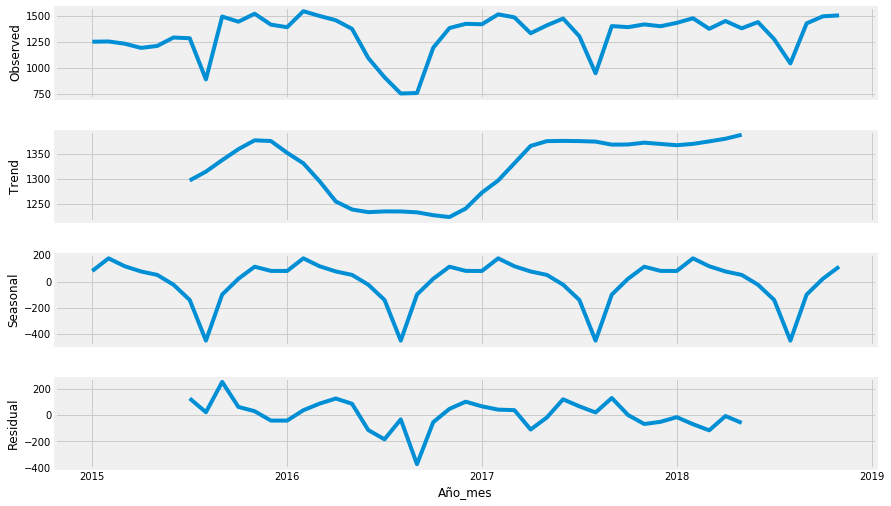

In [10]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_genova_WE_before_MC, model = 'additive') # Our serie is additive

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [11]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_genova_WE_before_MC, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# We can confirm the serie is stationary since the obtained p-value < 0.05

Test statistic: -3.4921525772629662
p-value: 0.008190934588364295
Lag: 0
Number of observations: 46
Critical Value (1%) = -3.5812576580093696
Critical Value (5%) = -2.9267849124681518
Critical Value (10%) = -2.6015409829867675


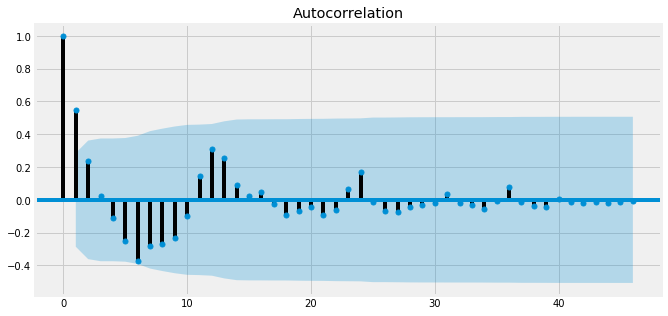

In [13]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_genova_WE_before_MC)
fig.set_size_inches(10,5)

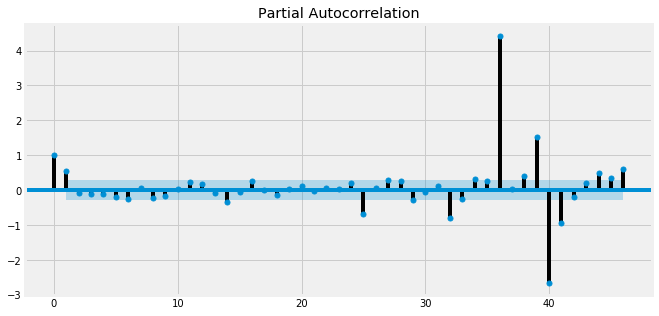

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_genova_WE_before_MC)
fig.set_size_inches(10,5)

### Now it is time to build the model

In [15]:
len(series_genova_WE_before_MC)

47

In [16]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_genova_WE = series_genova_WE_before_MC.loc['2015-01-31':'2018-05-31']
test_genova_WE = series_genova_WE_before_MC.loc['2018-06-01':'2018-11-30']

In [17]:
len(train_genova_WE), len(test_genova_WE)

(41, 6)

In [18]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_genova_WE, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2018-06-30','2018-11-30')
            y_truth = test_genova_WE['2018-06-30':'2018-11-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:708.1931085009663 - p-values:sigma2    0.393001
dtype: float64
The Mean Squared Error of our forecasts is 1890653.1
The Root Mean Squared Error of our forecasts is 1375.01
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:406.426274443315 - p-values:sigma2    8.566313e-07
dtype: float64
The Mean Squared Error of our forecasts is 4999.78
The Root Mean Squared Error of our forecasts is 70.71
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:604.3905328600458 - p-values:ar.S.L12    0.000000e+00
ma.S.L12    3.041853e-08
sigma2      0.000000e+00
dtype: float64
The Mean Squared Error of our forecasts is 25168.17
The Root Mean Squared Error of our forecasts is 158.64
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:386.0252080389582 - p-values:ar.S.L12    1.355298e-54
sigma2      9.404612e-03
dtype: float64
The Mean Squared Error of our forecasts is 117098.79
The Root Mean Squared Error of our forecasts is 342.2
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:663.6243804829528 - p-values:ma.L1     3.8016

In [55]:
# We select the model SARIMAX(1, 1, 0)x(0, 1, 0, 12) because at we see after:
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_genova_WE,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -191.384
Date:                            Wed, 15 May 2019   AIC                            386.768
Time:                                    23:47:09   BIC                            389.432
Sample:                                01-31-2015   HQIC                           387.583
                                     - 05-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3334      0.144     -2.314      0.021      -0.616      -0.051
sigma2      5.061e+04   1.52e+04   

In [56]:
# We obtain the residuals in order to check if they have a Normal distribution and no correlation

residuos = model.resid.values
residuos

array([1252.43665158,   13.78574299,  -25.01891181,  -39.6476434 ,
         17.84298973,   81.64669673,   -5.52480579, -396.58514135,
        597.72211744,  -36.57795264,   71.62832493, -101.93277403,
       -670.87448447,  130.20895358,   26.37225512,   -9.10956568,
       -101.76929423, -395.50417548, -298.65880971,  180.61068434,
       -520.06552096,  284.96173798,  274.52293686,  183.04036294,
         69.14534418,  -51.69258094,   -2.91625123, -105.63882456,
        121.46756763,  398.64450391,  130.40458888, -195.13275712,
        382.46937001, -295.9495078 , -311.79814937, -112.53562081,
         17.10894627,  -38.56329109,  -89.5302385 ,  203.48785432,
        -70.23737986])

In [57]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.727 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=1.2069652004126183, critical_values=array([0.532, 0.606, 0.727, 0.848, 1.009]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [58]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

(array([ 0.22700426,  0.24333589,  0.26791424,  1.15300364,  1.41413277,
         1.41799008,  2.06167267,  5.87919775,  6.37055285,  6.40277387,
         6.42776973, 21.36235106]),
 array([0.63375408, 0.88544233, 0.96594549, 0.88577398, 0.92276108,
        0.96475492, 0.95634813, 0.6607615 , 0.70233493, 0.78036547,
        0.8433536 , 0.0453196 ]),
 array([ 0.21116675,  0.22597917,  0.24769956,  1.00928812,  1.22790785,
         1.23104752,  1.74000585,  4.66973441,  5.03539401,  5.05862312,
         5.07606209, 15.1482216 ]),
 array([0.64585445, 0.89315996, 0.96954466, 0.90838435, 0.94217213,
        0.97532342, 0.97282127, 0.79222133, 0.83121202, 0.88722766,
        0.92742703, 0.23343056]))

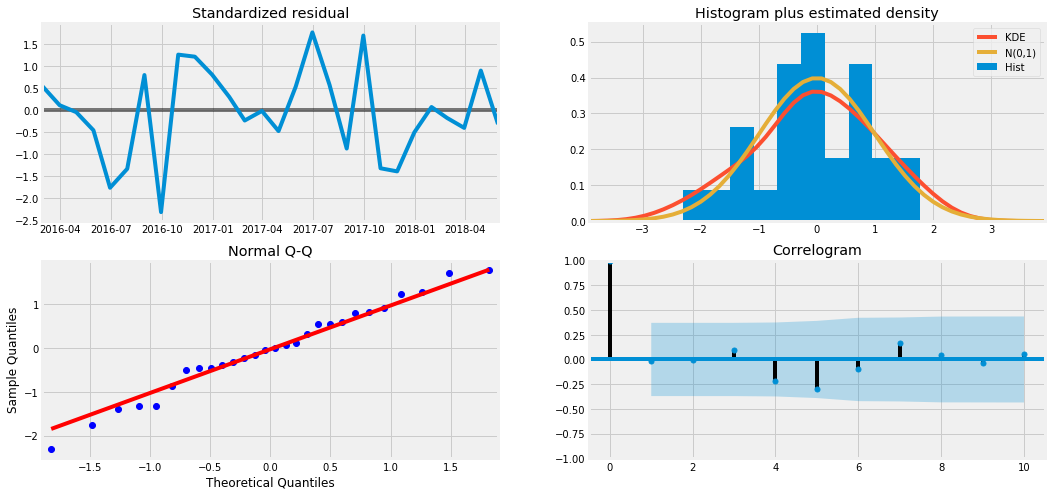

In [59]:
# Visualization of the residuals to confirm the results obtained in the cells above

model.plot_diagnostics(figsize=(16, 8))
plt.show()

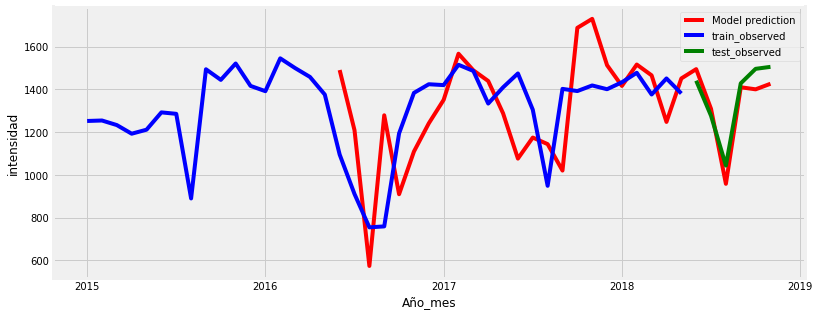

In [60]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model prediction')
train_genova_WE.plot(color = 'blue', label = 'train_observed')
test_genova_WE.plot(color = 'green', label = 'test_observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

In [61]:
# Let's make the numerical predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_forecasted

2018-06-30    1495.115428
2018-07-31    1309.151277
2018-08-31     958.295485
2018-09-30    1410.254143
2018-10-31    1400.614495
2018-11-30    1426.639987
Freq: M, dtype: float64

In [62]:
# Test values to compare vs forecasted values

y_truth = test_genova_WE['2018-06-30':'2018-11-30']
y_truth

Año_mes
2018-06-30    1441.025000
2018-07-31    1276.772273
2018-08-31    1043.610451
2018-09-30    1428.644051
2018-10-31    1496.549856
2018-11-30    1505.792157
Freq: M, Name: intensidad, dtype: float64

In [63]:
# Measure of the MSE and RMSE

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_truth = test_genova_WE['2018-06-30':'2018-11-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# As we see below, the result of the RMSE is very low, we are always talking about average intensity
# intensisy is vehicles/hour on a period of 15 min

The Mean Squared Error of our forecasts is 4509.94
The Root Mean Squared Error of our forecasts is 67.16


## Applying the model

In [64]:
# Apply the model selected before to the entire Serie

mod = sm.tsa.statespace.SARIMAX(series_genova_WE_before_MC,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   47
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -229.360
Date:                            Wed, 15 May 2019   AIC                            462.721
Time:                                    23:47:53   BIC                            465.773
Sample:                                01-31-2015   HQIC                           463.762
                                     - 11-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3332      0.120     -2.769      0.006      -0.569      -0.097
sigma2      4.235e+04   1.02e+04   

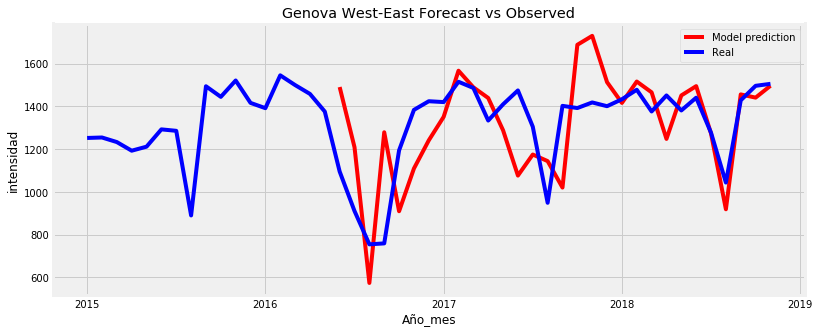

In [65]:
plt.figure(figsize=(12,5))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model prediction')
observed = series_genova_WE_before_MC.plot(color = 'blue', label = 'Real')

plt.title('Genova West-East Forecast vs Observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

### Forecasting vs Reality Madrid Central months

In [66]:
# Now we do a time series with the months with Madrid Central to compare the prediction of the model vs the real data

genova_WE_only_MC = genova_WE_only_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
genova_WE_only_MC = genova_WE_only_MC.set_index(genova_WE_only_MC['Año_mes'])
genova_WE_only_MC.index = pd.to_datetime(genova_WE_only_MC.index)
series_genova_WE_only_MC = genova_WE_only_MC['intensidad'].resample('M').mean()

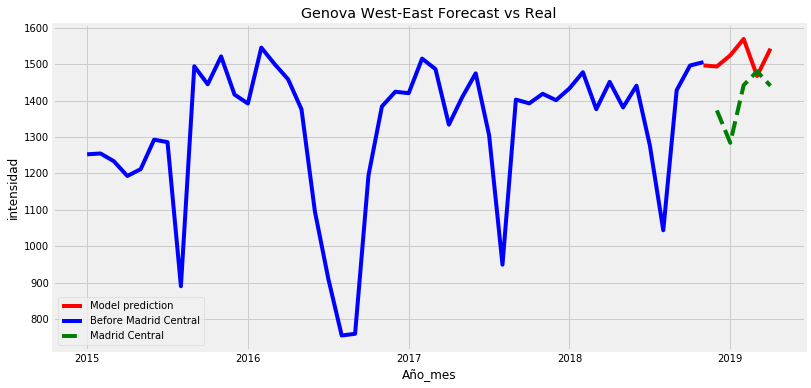

In [67]:
# Plot to compare the prediction of my model vs what really happened after the implementation of Madrid Central

plt.figure(figsize=(12,6))
forecast = model.predict('2018-11-30','2019-04-30').plot(color = 'red', label='Model prediction')
series_genova_WE_before_MC.plot(color = 'blue', label='Before Madrid Central')
series_genova_WE_only_MC.plot(linestyle='dashed', color = 'green', label = 'Madrid Central')

plt.title('Genova West-East Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

#### We see in the chart that after the implementation of Madrid Central the real observations were much lower than our model forecasted values. In this device our model expected more traffic than real one. What is more, if we see the historical evolution, normally after an increase in the traffic, it follows a little balance period but in this case it falls a lot.

#### In any case let's see with numerical figures

In [68]:
# Comparing the forecasted vs real on December 2018 and see the differences

y_forecasted_Dec18 = model.predict('2018-12-31')
y_truth_Dec18 = series_genova_WE_only_MC['2018-12-31']
y_forecasted_Dec18, y_truth_Dec18
print('On December it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Dec18, y_truth_Dec18))

On December it was expected an average of 1493 intensity and the result was 1373


In [69]:
# Here I compare the results of all the months of December of my dataset
# We can see clearly that the trend has some up and downs but especially the last observation falls more than ever
# ..in comparison to the historical trend

y_truth_Dec15 = series_genova_WE_before_MC['2015-12-31']
y_truth_Dec16 = series_genova_WE_before_MC['2016-12-31']
y_truth_Dec17 = series_genova_WE_before_MC['2017-12-31']
y_truth_Dec18 = series_genova_WE_only_MC['2018-12-31']

y_truth_Dec15, y_truth_Dec16, y_truth_Dec17, y_truth_Dec18

(1416.6347363328496,
 1424.4131878557876,
 1401.1507215392837,
 1373.1465844402278)

In [70]:
# Comparing the forecasted vs real on January 2019 and see the differences

y_forecasted_Jan19 = model.predict('2019-01-31')
y_truth_Jan19 = series_genova_WE_only_MC['2019-01-31']
y_forecasted_Jan19, y_truth_Jan19
print('On January it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Jan19, y_truth_Jan19))

On January it was expected an average of 1524 intensity and the result was 1284


In [71]:
# Here I compare the results of all the months of January of my dataset
# After years of continuos growth on intensity, we see clearly a big drop on January 2019

y_truth_Jan15 = series_genova_WE_before_MC['2015-01-31']
y_truth_Jan16 = series_genova_WE_before_MC['2016-01-31']
y_truth_Jan17 = series_genova_WE_before_MC['2017-01-31']
y_truth_Jan18 = series_genova_WE_before_MC['2018-01-31']
y_truth_Jan19 = series_genova_WE_only_MC['2019-01-31']

y_truth_Jan15, y_truth_Jan16, y_truth_Jan17, y_truth_Jan18, y_truth_Jan19

(1252.4366515837105,
 1391.9592030360532,
 1420.4032258064517,
 1433.6266033254158,
 1284.059885931559)

In [72]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_Feb19 = model.predict('2019-02-28')
y_truth_Feb19 = series_genova_WE_only_MC['2019-02-28']
y_forecasted_Feb19, y_truth_Feb19
print('On February it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Feb19, y_truth_Feb19))

On February it was expected an average of 1569 intensity and the result was 1442


In [73]:
# Here I compare the results of all the months of February of my dataset
# In this case the drop is not so significant as for January but still it continues the decreasing trend

y_truth_Feb15 = series_genova_WE_before_MC['2015-02-28']
y_truth_Feb16 = series_genova_WE_before_MC['2016-02-29']
y_truth_Feb17 = series_genova_WE_before_MC['2017-02-28']
y_truth_Feb18 = series_genova_WE_before_MC['2018-02-28']
y_truth_Feb19 = series_genova_WE_only_MC['2019-02-28']

y_truth_Feb15, y_truth_Feb16, y_truth_Feb17, y_truth_Feb18, y_truth_Feb19

(1254.6648793565685,
 1545.6435897435897,
 1515.5057773109243,
 1478.00262605042,
 1442.3962165002627)

In [74]:
# Comparing the forecasted vs real on March 2019 and see the differences

y_forecasted_March19 = model.predict('2019-03-31')
y_truth_March19 = series_genova_WE_only_MC['2019-03-31']
y_forecasted_March19, y_truth_March19
print('On March it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_March19, y_truth_March19))

On March it was expected an average of 1467 intensity and the result was 1480


In [75]:
# Here I compare the results of all the months of March of my dataset
# Surprisingly after years decreasing, on March we observe a growth.

y_truth_March15 = series_genova_WE_before_MC['2015-03-31']
y_truth_March16 = series_genova_WE_before_MC['2016-03-31']
y_truth_March17 = series_genova_WE_before_MC['2017-03-31']
y_truth_March18 = series_genova_WE_before_MC['2018-03-31']
y_truth_March19 = series_genova_WE_only_MC['2019-03-31']

y_truth_March15, y_truth_March16, y_truth_March17, y_truth_March18, y_truth_March19

(1233.2520247737018,
 1500.1122501281395,
 1486.5875356803044,
 1376.4647819837087,
 1480.4813753581661)

In [76]:
# Comparing the forecasted vs real on April 2019 and see the differences

y_forecasted_Apr19 = model.predict('2019-04-30')
y_truth_Apr19 = series_genova_WE_only_MC['2019-04-30']
y_forecasted_Apr19, y_truth_Apr19
print('On April it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Apr19, y_truth_Apr19))

On April it was expected an average of 1542 intensity and the result was 1440


In [77]:
# Here I compare the results of all the months of April of my dataset
# The evolution follow the trend of up and downs.

y_truth_Apr15 = series_genova_WE_before_MC['2015-04-30']
y_truth_Apr16 = series_genova_WE_before_MC['2016-04-30']
y_truth_Apr17 = series_genova_WE_before_MC['2017-04-30']
y_truth_Apr18 = series_genova_WE_before_MC['2018-04-30']
y_truth_Apr19 = series_genova_WE_only_MC['2019-04-30']

y_truth_Apr15, y_truth_Apr16, y_truth_Apr17, y_truth_Apr18, y_truth_Apr19

(1192.8488714425907,
 1458.639878695982,
 1333.9380530973451,
 1451.512254901961,
 1440.776028440833)

## Focus on PRINCESA North-South

In [526]:
# Split the information of each devices in:
    # Full dataset
    # Observations before Madrid Central (with the suffix "before_MC")
    # Observations since the beggining of Madrid Central (with the suffix "only_MC")

princesa_NS = final_data[final_data['id'] == 4354]
princesa_NS_before_MC = data_before_MC[data_before_MC['id'] == 4354]
princesa_NS_only_MC = data_only_MC[data_only_MC['id'] == 4354]

In [527]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

princesa_NS_before_MC = princesa_NS_before_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
princesa_NS_before_MC = princesa_NS_before_MC.set_index(princesa_NS_before_MC['Año_mes'])
princesa_NS_before_MC.index = pd.to_datetime(princesa_NS_before_MC.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_princesa_NS_before_MC = princesa_NS_before_MC['intensidad'].resample('M').mean()

Text(0.5, 1.0, 'Series Princesa North-South')

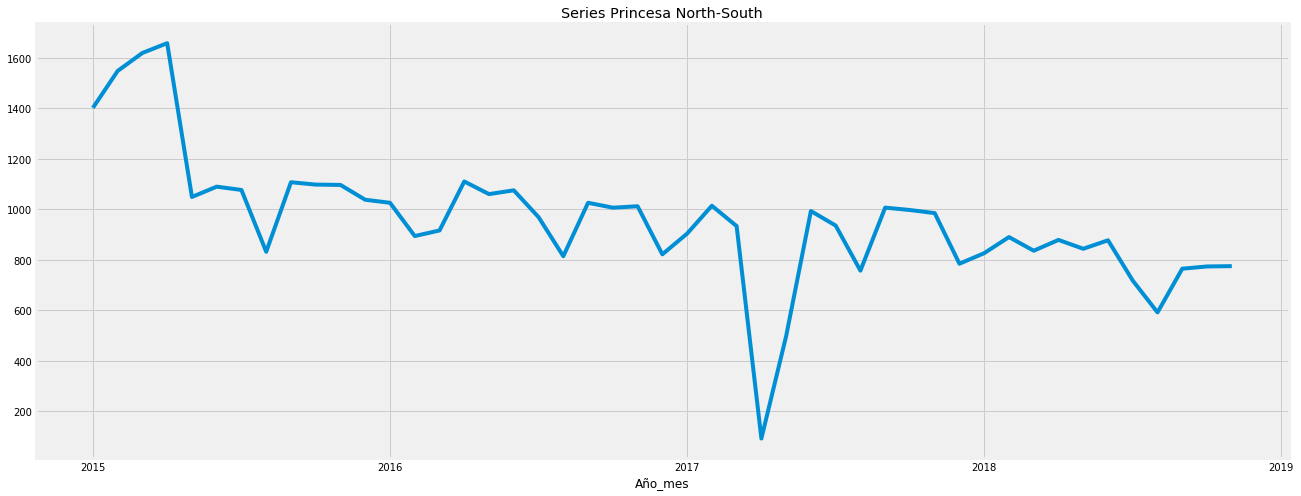

In [528]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us
# We observe a big drop but it was not a NaN value, it may be that the road was closed for a time

plt.figure(figsize=(20,8))
series_princesa_NS_before_MC.plot()
plt.title('Series Princesa North-South')

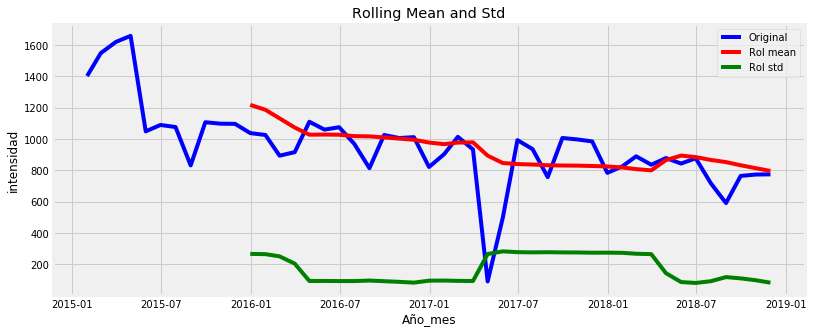

In [529]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_princesa_NS = series_princesa_NS_before_MC.rolling(12).mean()
rolstd_princesa_NS = series_princesa_NS_before_MC.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_princesa_NS_before_MC, label = 'Original', color = 'blue')
plt.plot(rolmean_princesa_NS, label = 'Rol mean', color = 'red')
plt.plot(rolstd_princesa_NS, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

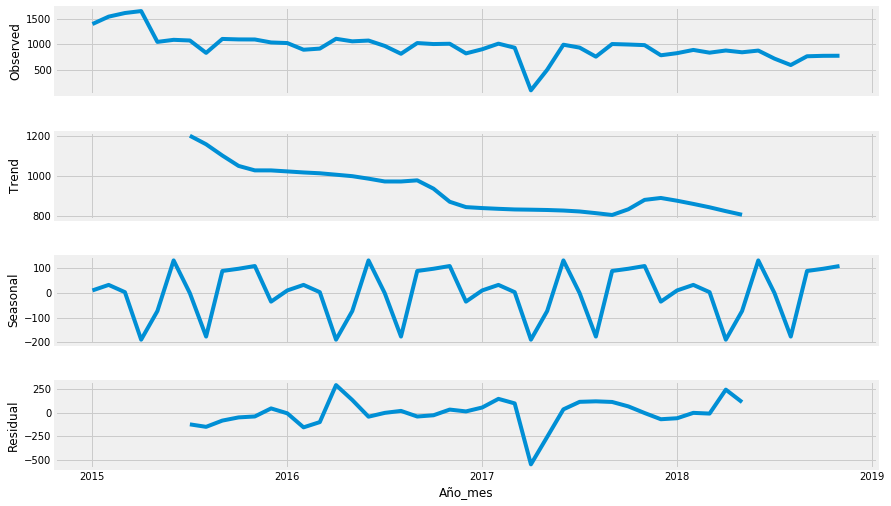

In [530]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_princesa_NS_before_MC, model = 'additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [531]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_princesa_NS_before_MC, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# Stationary since the p-value < 0.05

Test statistic: -3.1746995508214857
p-value: 0.02149667632286423
Lag: 2
Number of observations: 44
Critical Value (1%) = -3.5885733964124715
Critical Value (5%) = -2.929885661157025
Critical Value (10%) = -2.6031845661157025


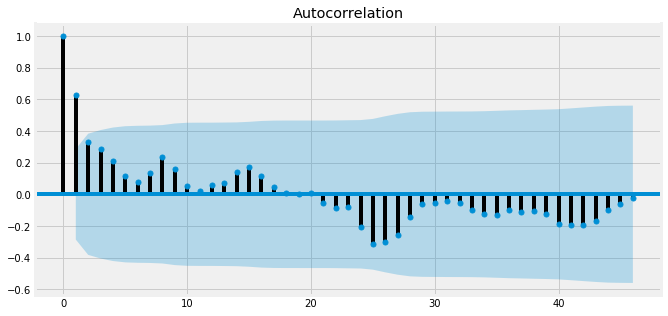

In [532]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_princesa_NS_before_MC) 
fig.set_size_inches(10,5)

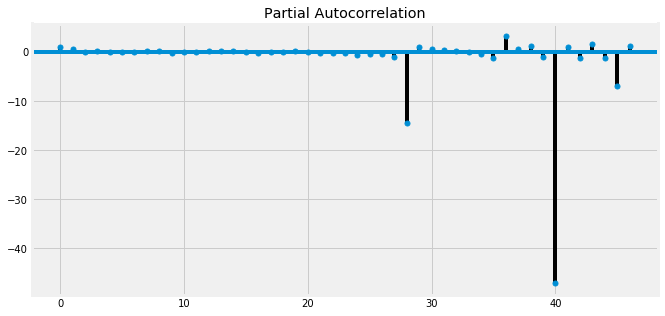

In [533]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_princesa_NS_before_MC)
fig.set_size_inches(10,5)

### Now it's time to build the model

In [534]:
len(series_princesa_NS_before_MC)

47

In [535]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not
    
train_princesa_NS = series_princesa_NS_before_MC.loc['2015-01-31':'2018-05-31']
test_princesa_NS = series_princesa_NS_before_MC.loc['2018-06-01':'2018-11-30']

In [536]:
len(train_princesa_NS), len(test_princesa_NS)

(41, 6)

In [537]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_princesa_NS, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2018-06-30','2018-11-30')
            y_truth = test_princesa_NS['2018-06-30':'2018-11-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:686.5857705890636 - p-values:sigma2    0.1043
dtype: float64
The Mean Squared Error of our forecasts is 570011.03
The Root Mean Squared Error of our forecasts is 754.99
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:424.5562537486651 - p-values:sigma2    2.018841e-07
dtype: float64
The Mean Squared Error of our forecasts is 40195.99
The Root Mean Squared Error of our forecasts is 200.49
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:627.4622604395212 - p-values:ar.S.L12    3.831541e-135
sigma2       1.757149e-06
dtype: float64
The Mean Squared Error of our forecasts is 22657.73
The Root Mean Squared Error of our forecasts is 150.52
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:628.2416465623829 - p-values:ar.S.L12    0.000000e+00
ma.S.L12    9.413196e-02
sigma2      2.370540e-07
dtype: float64
The Mean Squared Error of our forecasts is 30611.13
The Root Mean Squared Error of our forecasts is 174.96
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:424.2480872386408 - p-values:ar.S.L12    4.

ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:553.5804174605594 - p-values:ar.L1       0.476873
ar.S.L12    0.925367
ma.S.L12    0.987764
sigma2      0.985570
dtype: float64
The Mean Squared Error of our forecasts is 21484.56
The Root Mean Squared Error of our forecasts is 146.58
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:404.01226446182267 - p-values:ar.L1       3.554858e-01
ar.S.L12    3.326466e-03
sigma2      3.573379e-10
dtype: float64
The Mean Squared Error of our forecasts is 107524.89
The Root Mean Squared Error of our forecasts is 327.91
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:545.2319837273058 - p-values:ar.L1     3.337956e-01
ma.L1     2.701887e-04
sigma2    1.946548e-18
dtype: float64
The Mean Squared Error of our forecasts is 19136.48
The Root Mean Squared Error of our forecasts is 138.33
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:404.69706829319784 - p-values:ar.L1     4.768155e-01
ma.L1     9.662274e-04
sigma2    2.361455e-09
dtype: float64
The Mean Squared Error of our forecasts is 82059.91
The

In [538]:
# We select the model SARIMAX(1, 0, 0)x(1, 0, 1, 12) because:
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_princesa_NS,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   41
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood                -281.465
Date:                            Thu, 16 May 2019   AIC                            570.929
Time:                                    11:53:24   BIC                            577.783
Sample:                                01-31-2015   HQIC                           573.425
                                     - 05-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9738      0.042     22.974      0.000       0.891       1.057
ar.S.L12       0.9977      0.080   

In [539]:
# let's have a look at the residuals in order to test their distribution and correlation

residuos = model.resid.values
residuos

array([ 1.40230312e+03,  1.77060944e+02,  1.05928113e+02,  7.50042919e+01,
       -5.72218654e+02,  6.16212550e+01,  8.57788840e+00, -2.23758148e+02,
        2.90024423e+02,  1.23279859e+01,  1.98837076e+01, -3.78023826e+01,
        7.26010822e+00, -1.17273494e+02,  3.57070756e+01,  2.09154701e+02,
       -6.96391219e+00,  3.41055770e+01, -8.51539286e+01, -1.28380561e+02,
        2.15523051e+02, -3.28901200e-01,  2.38836080e+01, -1.70310771e+02,
        9.54300611e+01,  1.26013424e+02, -6.50954742e+01, -8.33452645e+02,
        4.22273178e+02,  4.98582188e+02, -3.54952057e+01, -1.48610450e+02,
        2.44724908e+02,  9.27871932e+00,  4.99669526e+00, -1.75118456e+02,
        5.10942268e+01,  7.30436739e+01, -3.94552770e+01,  7.64502785e+01,
       -1.18549722e+01])

In [540]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.727 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=2.990350660073709, critical_values=array([0.532, 0.606, 0.727, 0.848, 1.009]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [541]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12, boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([0.01057016, 1.18440781, 1.21670532, 1.89515717, 1.93316213,
        2.13945497, 2.70925024, 4.61592625, 4.68708997, 4.83000029,
        5.08020156, 5.08201589]),
 array([0.91811276, 0.55310695, 0.74900054, 0.75503458, 0.85831391,
        0.90643636, 0.91053417, 0.79772613, 0.86068815, 0.90224088,
        0.9272203 , 0.95518328]),
 array([0.0098327 , 1.07447615, 1.10301814, 1.68680229, 1.7186204 ,
        1.88653318, 2.33706897, 3.80033195, 3.853291  , 3.95631937,
        4.1308784 , 4.13210202]),
 array([0.92101124, 0.58435998, 0.77634554, 0.79311359, 0.88654561,
        0.9298326 , 0.9388584 , 0.87467383, 0.92080034, 0.94929598,
        0.96593081, 0.98093286]))

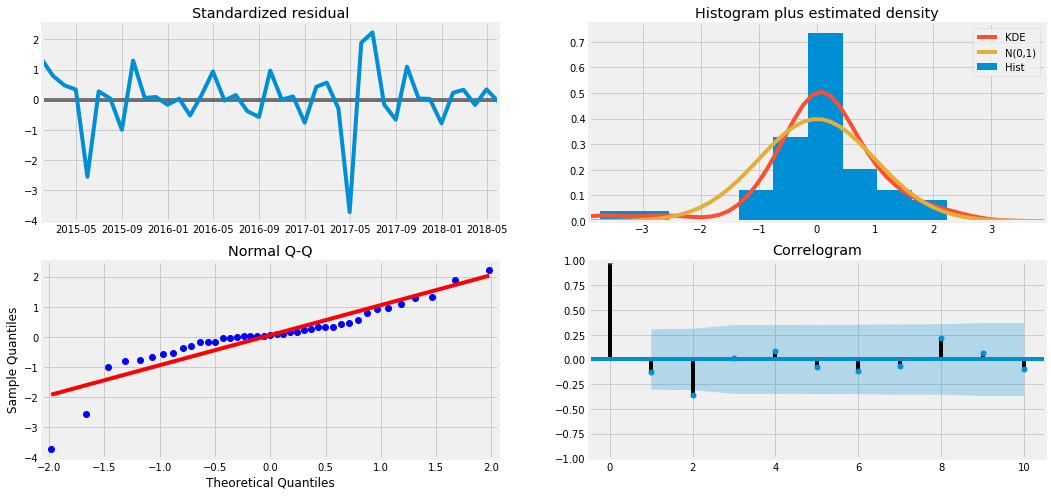

In [542]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

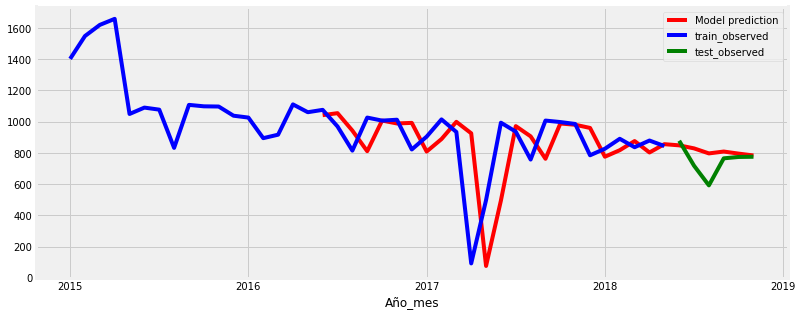

In [543]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model prediction')
train_princesa_NS.plot(color = 'blue', label = 'train_observed')
test_princesa_NS.plot(color = 'green', label = 'test_observed')
plt.legend()
plt.show()

In [544]:
# Let's make the predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_forecasted

2018-06-30    848.174696
2018-07-31    828.769193
2018-08-31    796.565462
2018-09-30    808.505705
2018-10-31    795.217007
2018-11-30    783.424629
Freq: M, dtype: float64

In [545]:
# Test values to compare real vs predicted ones

y_truth = test_princesa_NS['2018-06-30':'2018-11-30']
y_truth

Año_mes
2018-06-30    877.542157
2018-07-31    717.732824
2018-08-31    591.768646
2018-09-30    764.964706
2018-10-31    773.777040
2018-11-30    775.082884
Freq: M, Name: intensidad, dtype: float64

In [546]:
# Computation of MSE and RMSE

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_truth = test_princesa_NS['2018-06-30':'2018-11-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# Good RMSE of the model

The Mean Squared Error of our forecasts is 9593.06
The Root Mean Squared Error of our forecasts is 97.94


## Applying the model

In [547]:
# Application of the model to the entire serie

mod = sm.tsa.statespace.SARIMAX(series_princesa_NS_before_MC,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 12))
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   47
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood                -319.687
Date:                            Thu, 16 May 2019   AIC                            647.374
Time:                                    11:53:28   BIC                            654.774
Sample:                                01-31-2015   HQIC                           650.158
                                     - 11-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9656      0.035     27.616      0.000       0.897       1.034
ar.S.L12       0.9979      0.029   

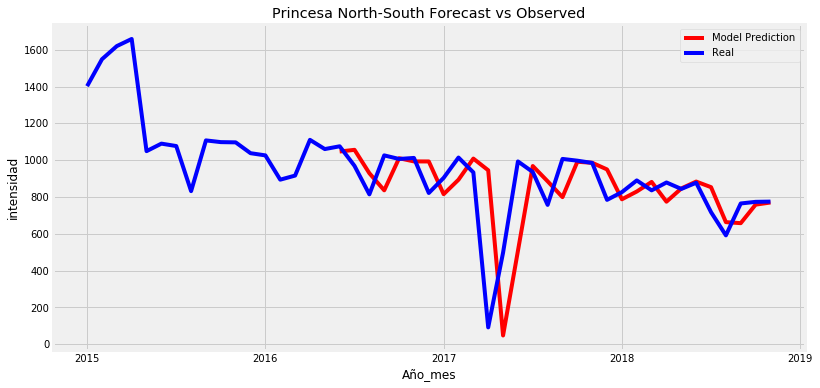

In [552]:
plt.figure(figsize=(12,6))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Prediction')
observed = series_princesa_NS_before_MC.plot(color = 'blue', label = 'Real')

plt.title('Princesa North-South Forecast vs Observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()


### Forecasting vs Reality Madrid Central months

In [550]:
# Now we do a time series with the months with Madrid Central to compare the prediction of the model vs the real data

princesa_NS_only_MC = princesa_NS_only_MC.loc[:, ['Año_mes','intensidad','carga','volumen','ocupacion','Madrid-Central']]
princesa_NS_only_MC = princesa_NS_only_MC.set_index(princesa_NS_only_MC['Año_mes'])
princesa_NS_only_MC.index = pd.to_datetime(princesa_NS_only_MC.index)
series_princesa_NS_only_MC = princesa_NS_only_MC['intensidad'].resample('M').mean()

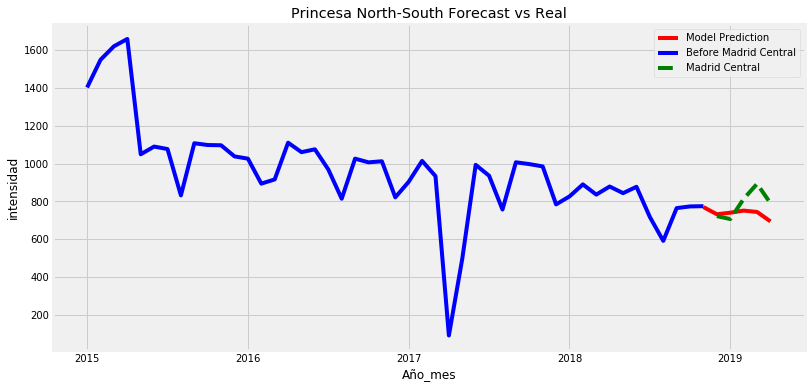

In [551]:
plt.figure(figsize=(12,6))
forecast = model.predict(start = '2018-11-30',end ='2019-04-30').plot(color = 'red', label='Model Prediction')
series_princesa_NS_before_MC.plot(color = 'blue', label='Before Madrid Central')
series_princesa_NS_only_MC.plot(linestyle='dashed', color = 'green', label = 'Madrid Central')

plt.title('Princesa North-South Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

#### In this case we see that the traffic intensity was higher on March and April than expected but it can be since we don't have to forget that the first months the access was not punished with fines ;)

### Let's see numerical values

In [142]:
# Comparing the forecasted vs real on December 2018 and see the differences

y_forecasted_Dec18 = model.predict('2018-12-31')
y_truth_Dec18 = series_princesa_NS_only_MC['2018-12-31']
y_forecasted_Dec18, y_truth_Dec18
print('On December it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Dec18, y_truth_Dec18))

On December it was expected an average of 732 intensity and the result was 722


In [143]:
# Here I compare the results of all the months of December of my dataset
# We can observe a continuos decrease in the traffic

y_truth_Dec15 = series_princesa_NS_before_MC['2015-12-31']
y_truth_Dec16 = series_princesa_NS_before_MC['2016-12-31']
y_truth_Dec17 = series_princesa_NS_before_MC['2017-12-31']
y_truth_Dec18 = series_princesa_NS_only_MC['2018-12-31']

y_truth_Dec15, y_truth_Dec16, y_truth_Dec17, y_truth_Dec18

(1038.1175616835994, 821.8187855787477, 784.6023454157782, 722.5401044138586)

In [144]:
# Comparing the forecasted vs real on January 2019 and see the differences

y_forecasted_Jan19 = model.predict('2019-01-31')
y_truth_Jan19 = series_princesa_NS_only_MC['2019-01-31']
y_forecasted_Jan19, y_truth_Jan19
print('On January it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Jan19, y_truth_Jan19))

On January it was expected an average of 740 intensity and the result was 707


In [145]:
# Here I compare the results of all the months of January of my dataset
# January trens shows very relevant decreases in the traffic

y_truth_Jan15 = series_princesa_NS_before_MC['2015-01-31']
y_truth_Jan16 = series_princesa_NS_before_MC['2016-01-31']
y_truth_Jan17 = series_princesa_NS_before_MC['2017-01-31']
y_truth_Jan18 = series_princesa_NS_before_MC['2018-01-31']
y_truth_Jan19 = series_princesa_NS_only_MC['2019-01-31']

y_truth_Jan15, y_truth_Jan16, y_truth_Jan17, y_truth_Jan18, y_truth_Jan19

(1402.3031226199544,
 1026.1636622390893,
 903.9397533206832,
 826.5337805462386,
 707.0352548832777)

In [146]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_Feb19 = model.predict('2019-02-28')
y_truth_Feb19 = series_princesa_NS_only_MC['2019-02-28']
y_forecasted_Feb19, y_truth_Feb19
print('On February it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Feb19, y_truth_Feb19))

On February it was expected an average of 751 intensity and the result was 813


In [147]:
# Here I compare the results of all the months of February of my dataset
# Despite the model predicted less intensity than in reality, we can observe after some historical up&downs that this Feb19..
# ..it decreased and hisorically was raising

y_truth_Feb15 = series_princesa_NS_before_MC['2015-02-28']
y_truth_Feb16 = series_princesa_NS_before_MC['2016-02-29']
y_truth_Feb17 = series_princesa_NS_before_MC['2017-02-28']
y_truth_Feb18 = series_princesa_NS_before_MC['2018-02-28']
y_truth_Feb19 = series_princesa_NS_only_MC['2019-02-28']

y_truth_Feb15, y_truth_Feb16, y_truth_Feb17, y_truth_Feb18, y_truth_Feb19

(1548.5554965480617,
 894.2604006163328,
 1014.4185924369748,
 890.1985294117648,
 813.761122881356)

In [148]:
# Comparing the forecasted vs real on March 2019 and see the differences

y_forecasted_March19 = model.predict('2019-03-31')
y_truth_March19 = series_princesa_NS_only_MC['2019-03-31']
y_forecasted_March19, y_truth_March19
print('On March it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_March19, y_truth_March19))

On March it was expected an average of 744 intensity and the result was 893


In [149]:
# Here I compare the results of all the months of March of my dataset
# Despite the model predicted less intensity than reality, we can observe an historical decreasing trend
# On this year March has increased again

y_truth_March15 = series_princesa_NS_before_MC['2015-03-31']
y_truth_March16 = series_princesa_NS_before_MC['2016-03-31']
y_truth_March17 = series_princesa_NS_before_MC['2017-03-31']
y_truth_March18 = series_princesa_NS_before_MC['2018-03-31']
y_truth_March19 = series_princesa_NS_only_MC['2019-03-31']

y_truth_March15, y_truth_March16, y_truth_March17, y_truth_March18, y_truth_March19

(1619.9298664122136,
 916.460593654043,
 933.7407594936709,
 836.1969333972208,
 893.070430733411)

In [150]:
# Comparing the forecasted vs real on April 2019 and see the differences

y_forecasted_Apr19 = model.predict('2019-04-30')
y_truth_Apr19 = series_princesa_NS_only_MC['2019-04-30']
y_forecasted_Apr19, y_truth_Apr19
print('On April it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Apr19, y_truth_Apr19))

On April it was expected an average of 694 intensity and the result was 790


In [151]:
# Here I compare the results of all the months of April of my dataset
# We see clearly that 2017 is not useful since as we sawin the time series happened, a specific event may took place
# in any case, the trend seems to be going down

y_truth_Apr15 = series_princesa_NS_before_MC['2015-04-30']
y_truth_Apr16 = series_princesa_NS_before_MC['2016-04-30']
y_truth_Apr17 = series_princesa_NS_before_MC['2017-04-30']
y_truth_Apr18 = series_princesa_NS_before_MC['2018-04-30']
y_truth_Apr19 = series_princesa_NS_only_MC['2019-04-30']

y_truth_Apr15, y_truth_Apr16, y_truth_Apr17, y_truth_Apr18, y_truth_Apr19

(1658.625715773035,
 1110.5740318906605,
 91.87009345794392,
 878.9848039215686,
 790.8070086338242)

## Focus on GRAN VIA South-North

In [499]:
# Split the information of each devices in:
    # Full dataset
    # Observations before Madrid Central (with the suffix "before_MC")
    # Observations since the beggining of Madrid Central (with the suffix "only_MC")

granvia_SN = final_data[final_data['id'] == 4305]
granvia_SN_before_MC = data_before_MC[data_before_MC['id'] == 4305]
granvia_SN_only_MC = data_only_MC[data_only_MC['id'] == 4305]

In [500]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

granvia_SN_before_MC = granvia_SN_before_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
granvia_SN_before_MC = granvia_SN_before_MC.set_index(granvia_SN_before_MC['Año_mes'])
granvia_SN_before_MC.index = pd.to_datetime(granvia_SN_before_MC.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_granvia_SN_before_MC = granvia_SN_before_MC['intensidad'].resample('M').mean()

Text(0.5, 1.0, 'Gran Via South-North')

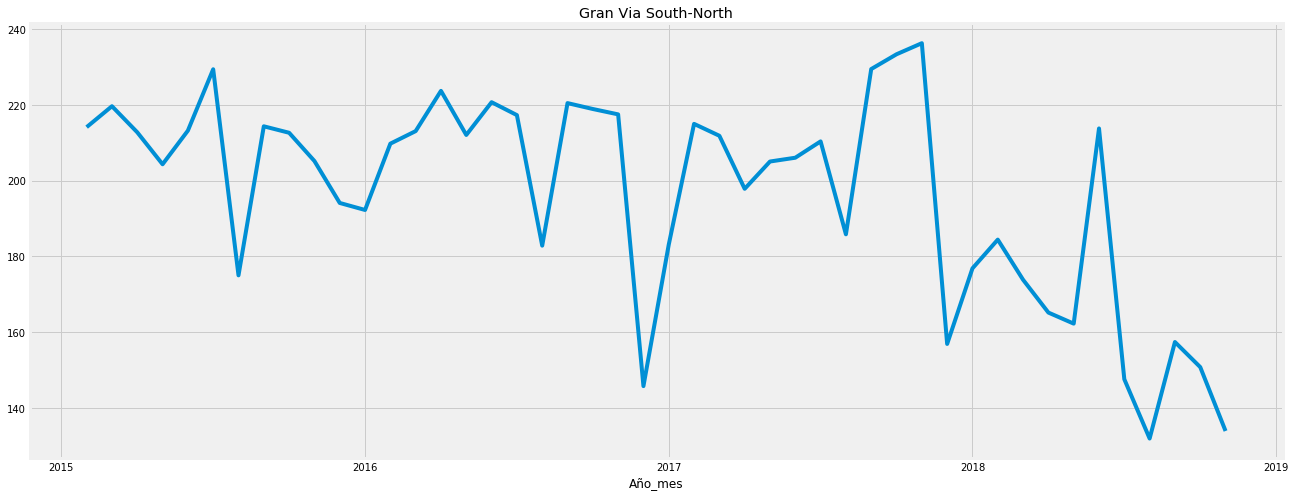

In [501]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_granvia_SN_before_MC.plot()
plt.title('Gran Via South-North')

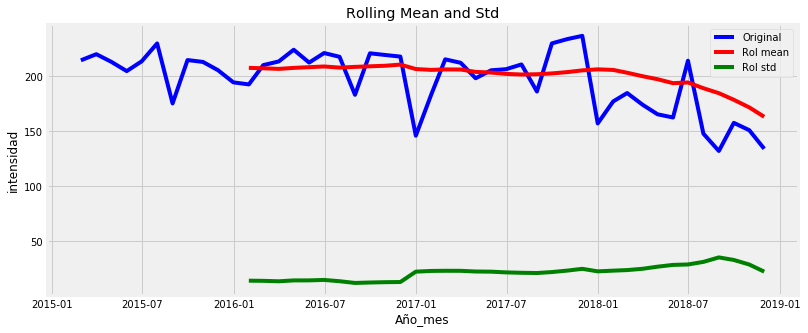

In [502]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_granvia_SN = series_granvia_SN_before_MC.rolling(12).mean()
rolstd_granvia_SN = series_granvia_SN_before_MC.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_granvia_SN_before_MC, label = 'Original', color = 'blue')
plt.plot(rolmean_granvia_SN, label = 'Rol mean', color = 'red')
plt.plot(rolstd_granvia_SN, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

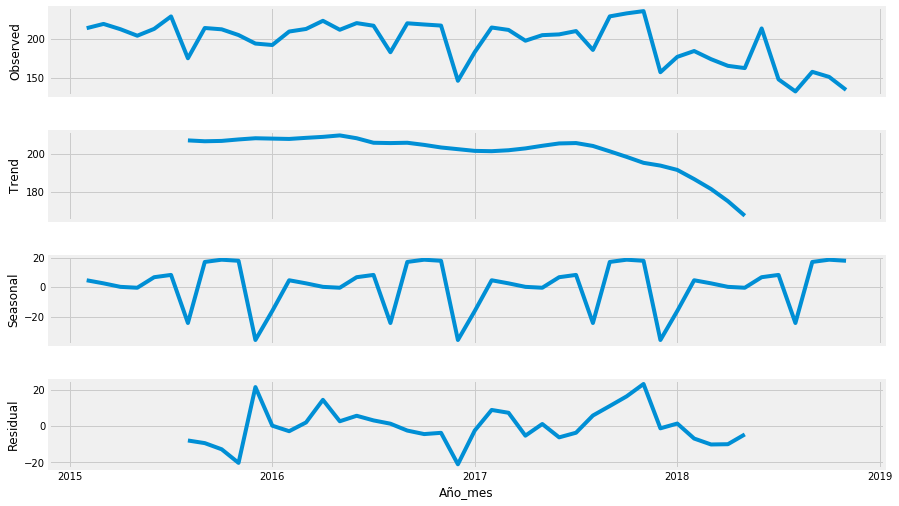

In [503]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_granvia_SN_before_MC, model = 'additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [504]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary
    
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_granvia_SN_before_MC, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# Non-Stationary since the p-value > 0.05, let see the diff()

Test statistic: 0.9931087114020286
p-value: 0.9941927026659654
Lag: 6
Number of observations: 39
Critical Value (1%) = -3.610399601308181
Critical Value (5%) = -2.939108945868946
Critical Value (10%) = -2.6080629651545038


In [505]:
series_granvia_SN_before_MC_diff = series_granvia_SN_before_MC.diff()
series_granvia_SN_before_MC_diff = series_granvia_SN_before_MC_diff[1:]

In [506]:
# Recompute the adfuller test and we see that with 1 diff the serie is stationary  (p-value < 0.05) 
# so in our model we need to apply 1 diff

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_granvia_SN_before_MC_diff, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))

Test statistic: -4.129682035865199
p-value: 0.0008647118143835976
Lag: 5
Number of observations: 39
Critical Value (1%) = -3.610399601308181
Critical Value (5%) = -2.939108945868946
Critical Value (10%) = -2.6080629651545038


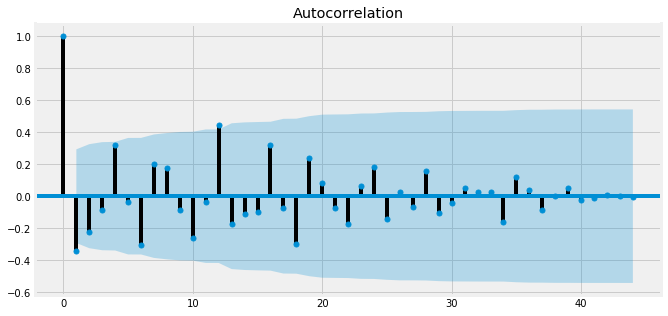

In [507]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals
    
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_granvia_SN_before_MC_diff) # We use the serie diff
fig.set_size_inches(10,5)

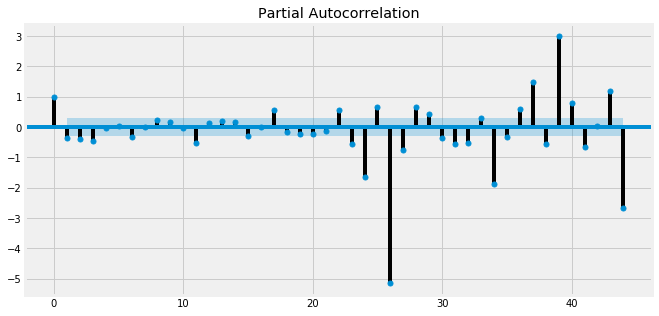

In [508]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_granvia_SN_before_MC_diff)
fig.set_size_inches(10,5)

### Now it's time to build the model

In [509]:
len(series_granvia_SN_before_MC)

46

In [510]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_granvia_SN = series_granvia_SN_before_MC.loc['2015-01-31':'2018-05-31']
test_granvia_SN = series_granvia_SN_before_MC.loc['2018-06-01':'2018-11-30']

In [511]:
len(train_granvia_SN), len(test_granvia_SN)

(40, 6)

In [512]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_granvia_SN, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2018-06-30','2018-11-30')
            y_truth = test_granvia_SN['2018-06-30':'2018-11-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:540.8595385716294 - p-values:sigma2    0.519619
dtype: float64
The Mean Squared Error of our forecasts is 25061.2
The Root Mean Squared Error of our forecasts is 158.31
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:246.7282692335919 - p-values:sigma2    0.000017
dtype: float64
The Mean Squared Error of our forecasts is 4894.62
The Root Mean Squared Error of our forecasts is 69.96
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:410.0749402086867 - p-values:ar.S.L12    0.000000
sigma2      0.000346
dtype: float64
The Mean Squared Error of our forecasts is 4773.2
The Root Mean Squared Error of our forecasts is 69.09
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:411.8055897982147 - p-values:ar.S.L12    0.000000
ma.S.L12    0.599479
sigma2      0.000766
dtype: float64
The Mean Squared Error of our forecasts is 4924.11
The Root Mean Squared Error of our forecasts is 70.17
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:248.55322290896092 - p-values:ar.S.L12    0.714316
sigma2      0.000056
dtyp

In [513]:
# The model selected is SARIMAX(0, 1, 0)x(0, 0, 0, 12):
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
    # Anderson test for Normally Distribution p-value > 0.05
    # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_granvia_SN,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             intensidad   No. Observations:                   40
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -181.932
Date:                Thu, 16 May 2019   AIC                            365.863
Time:                        11:51:56   BIC                            367.527
Sample:                    02-28-2015   HQIC                           366.460
                         - 05-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       659.8188    103.312      6.387      0.000     457.330     862.307
Ljung-Box (Q):                       66.28   Jarque-Bera (JB):                13.47
Prob(Q):                              0.00   Pr

In [514]:
# let's have a look at the residuals in order to test their distribution and correlation

residuos = model.resid.values
residuos

array([214.11684126,   5.52086055,  -6.88193918,  -8.4353976 ,
         8.87813034,  16.18983461, -54.36982048,  39.31844009,
        -1.70477695,  -7.45403285, -11.06077799,  -1.85262794,
        17.49475334,   3.31369603,  10.61749154, -11.63826885,
         8.64224677,  -3.4049286 , -34.43617834,  37.60563289,
        -1.55612227,  -1.41681323, -71.69402301,  37.326432  ,
        31.86032845,  -3.13985633, -13.99357578,   7.20204793,
         1.00072709,   4.31024796, -24.52365682,  43.60645105,
         3.90290443,   2.92265827, -79.3543484 ,  19.94429118,
         7.58535575, -10.59112218,  -8.65728724,  -2.9172015 ])

In [515]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.726 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=3.355269430347029, critical_values=array([0.531, 0.605, 0.726, 0.847, 1.007]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [516]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([ 0.43101611,  0.70899443,  1.09046443,  2.18949225,  2.26761573,
         4.91657477,  5.82665639,  5.96150737,  6.13788275,  6.74340549,
         6.9615807 , 10.50754423]),
 array([0.51149078, 0.70152607, 0.77937649, 0.70095348, 0.81101131,
        0.5545568 , 0.56012953, 0.65154378, 0.72604302, 0.74942662,
        0.80218618, 0.57152499]),
 array([0.40022925, 0.65173344, 0.98779034, 1.92981419, 1.99491709,
        4.1393125 , 4.85437664, 4.95712024, 5.08730207, 5.5198183 ,
        5.6704631 , 8.03443878]),
 array([0.52697089, 0.72190139, 0.8042063 , 0.74866614, 0.84984791,
        0.65783001, 0.67772895, 0.76214921, 0.82663245, 0.85386557,
        0.89442259, 0.78243335]))

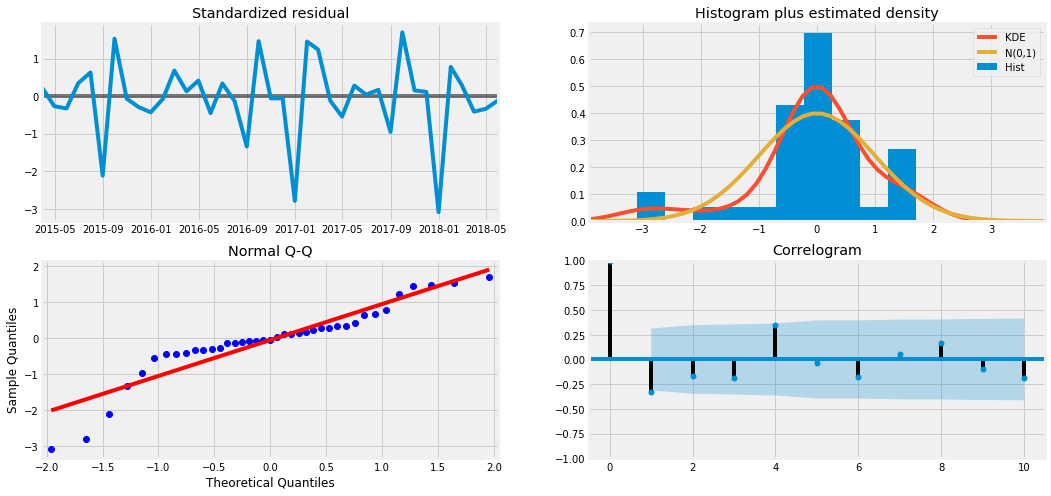

In [517]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

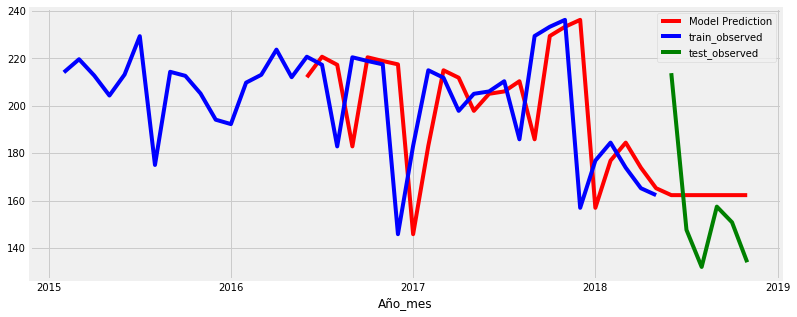

In [518]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Prediction')
train_granvia_SN.plot(color = 'blue', label = 'train_observed')
test_granvia_SN.plot(color = 'green', label = 'test_observed')
plt.legend()
plt.show()

In [519]:
# Let's make the predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_forecasted

2018-06-30    162.276616
2018-07-31    162.276616
2018-08-31    162.276616
2018-09-30    162.276616
2018-10-31    162.276616
2018-11-30    162.276616
Freq: M, dtype: float64

In [520]:
# test value to compare vs the prediction for the MSe and RMSE

y_truth = test_granvia_SN['2018-06-30':'2018-11-30']
y_truth

Año_mes
2018-06-30    213.772437
2018-07-31    147.607697
2018-08-31    131.961429
2018-09-30    157.422266
2018-10-31    150.803512
2018-11-30    133.952217
Freq: M, Name: intensidad, dtype: float64

In [521]:
# Computation of MSE and RMSE

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_truth = test_granvia_SN['2018-06-30':'2018-11-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# Good RMSE

The Mean Squared Error of our forecasts is 790.58
The Root Mean Squared Error of our forecasts is 28.12


## Applying the model

In [522]:
# Application of the model to the entire serie

mod = sm.tsa.statespace.SARIMAX(series_granvia_SN_before_MC,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 0, 12))
model = mod.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             intensidad   No. Observations:                   46
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -212.959
Date:                Thu, 16 May 2019   AIC                            427.917
Time:                        11:51:57   BIC                            429.724
Sample:                    02-28-2015   HQIC                           428.591
                         - 11-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       755.1877    120.832      6.250      0.000     518.361     992.015
Ljung-Box (Q):                       90.24   Jarque-Bera (JB):                 8.01
Prob(Q):                              0.00   Pr

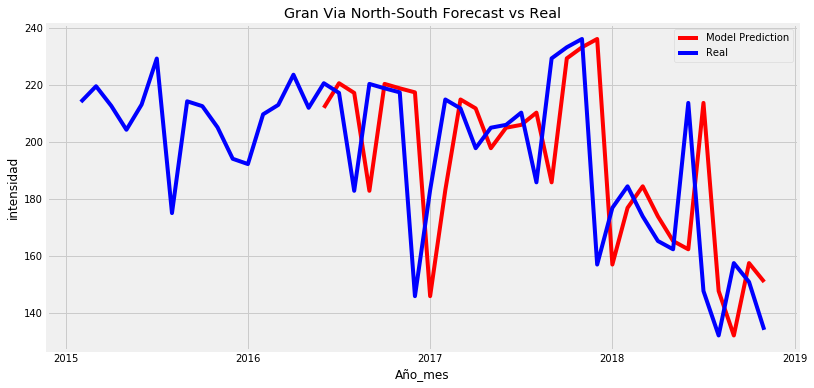

In [523]:
plt.figure(figsize=(12,6))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Prediction')
observed = series_granvia_SN_before_MC.plot(color = 'blue', label = 'Real')

plt.title('Gran Via North-South Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()


### Forecasting vs Reality Madrid Central months

In [524]:
# Now we do a time series with the months with Madrid Central to compare the prediction of the model vs the real data

granvia_SN_only_MC = granvia_SN_only_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
granvia_SN_only_MC = granvia_SN_only_MC.set_index(granvia_SN_only_MC['Año_mes'])
granvia_SN_only_MC.index = pd.to_datetime(granvia_SN_only_MC.index)
series_granvia_SN_only_MC = granvia_SN_only_MC['intensidad'].resample('M').mean()

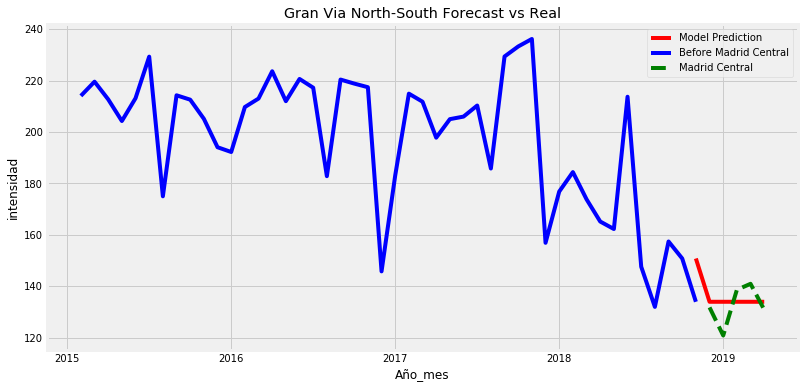

In [525]:
plt.figure(figsize=(12,6))
forecast = model.predict('2018-11-30','2019-04-30').plot(color = 'red', label='Model Prediction')
series_granvia_SN_before_MC.plot(color = 'blue', label='Before Madrid Central')
series_granvia_SN_only_MC.plot(linestyle='dashed', color = 'green', label = 'Madrid Central')

plt.title('Gran Via North-South Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()


#### Real figures lower than expected at the beginning but higher afterwards. It can be explained that the model is impacted by the working period of Gran Via that lasted more than half of the year

### Let's see numerical values

In [218]:
# Comparing the forecasted vs real on December 2018 and see the differences

y_forecasted_Dec18 = model.predict('2018-12-31')
y_truth_Dec18 = series_granvia_SN
y_forecasted_Dec18, y_truth_Dec18
print('On December it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Dec18, y_truth_Dec18))

On December it was expected an average of 133 intensity and the result was 131


In [219]:
# Here I compare the results of all the months of December of my dataset
# We can observe all in all a general decrease in the months of December except for 2017

y_truth_Dec15 = series_granvia_SN_before_MC['2015-12-31']
y_truth_Dec16 = series_granvia_SN_before_MC['2016-12-31']
y_truth_Dec17 = series_granvia_SN_before_MC['2017-12-31']
y_truth_Dec18 = series_granvia_SN_only_MC['2018-12-31']

y_truth_Dec15, y_truth_Dec16, y_truth_Dec17, y_truth_Dec18

(194.11736178467507, 145.79222011385198, 156.9125799573561, 131.76138519924098)

In [220]:
# Comparing the forecasted vs real on January 2019 and see the differences

y_forecasted_Jan19 = model.predict('2019-01-31')
y_truth_Jan19 = series_granvia_SN_only_MC['2019-01-31']
y_forecasted_Jan19, y_truth_Jan19
print('On January it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Jan19, y_truth_Jan19))

On January it was expected an average of 133 intensity and the result was 120


In [221]:
# Here I compare the results of all the months of January of my dataset
# On Jan 2019 the reduction of the traffic intensity was much intense than the historical decreasing trend for Gran Via

y_truth_Jan16 = series_granvia_SN_before_MC['2016-01-31']
y_truth_Jan17 = series_granvia_SN_before_MC['2017-01-31']
y_truth_Jan18 = series_granvia_SN_before_MC['2018-01-31']
y_truth_Jan19 = series_granvia_SN_only_MC['2019-01-31']

y_truth_Jan16, y_truth_Jan17, y_truth_Jan18, y_truth_Jan19

(192.2647338403042, 183.1186521120076, 176.8568711364717, 120.83491461100569)

In [222]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_Feb19 = model.predict('2019-02-28')
y_truth_Feb19 = series_granvia_SN_only_MC['2019-02-28']
y_forecasted_Feb19, y_truth_Feb19
print('On February it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Feb19, y_truth_Feb19))

On February it was expected an average of 133 intensity and the result was 138


In [223]:
# Here I compare the results of all the months of January of my dataset
# As of Jan 2019 for Feb 2019 the reduction of the traffic intensity was much intense than the historical trend for Gran Via
# General pattern of reduction of the traffic

y_truth_Feb15 = series_granvia_SN_before_MC['2015-02-28']
y_truth_Feb16 = series_granvia_SN_before_MC['2016-02-29']
y_truth_Feb17 = series_granvia_SN_before_MC['2017-02-28']
y_truth_Feb18 = series_granvia_SN_before_MC['2018-02-28']
y_truth_Feb19 = series_granvia_SN_only_MC['2019-02-28']

y_truth_Feb15, y_truth_Feb16, y_truth_Feb17, y_truth_Feb18, y_truth_Feb19

(214.11684125705077,
 209.75948717948717,
 214.97898055701523,
 184.4422268907563,
 138.6186974789916)

In [224]:
# Comparing the forecasted vs real on March 2019 and see the differences

y_forecasted_March19 = model.predict('2019-03-31')
y_truth_March19 = series_granvia_SN_only_MC['2019-03-31']
y_forecasted_March19, y_truth_March19
print('On March it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_March19, y_truth_March19))

On March it was expected an average of 133 intensity and the result was 140


In [225]:
# Here I compare the results of all the months of January of my dataset
# Last 2 months of march show an important drop in the traffic: this may be impacted of course fo...
# ...the working activities in the street performed during 2018. They started on March 2018

y_truth_March15 = series_granvia_SN_before_MC['2015-03-31']
y_truth_March16 = series_granvia_SN_before_MC['2016-03-31']
y_truth_March17 = series_granvia_SN_before_MC['2017-03-31']
y_truth_March18 = series_granvia_SN_before_MC['2018-03-31']
y_truth_March19 = series_granvia_SN_only_MC['2019-03-31']

y_truth_March15, y_truth_March16, y_truth_March17, y_truth_March18, y_truth_March19

(219.63770180436848,
 213.07318321392017,
 211.8391242265588,
 173.8511047070125,
 140.95)

In [226]:
# Comparing the forecasted vs real on April 2019 and see the differences

y_forecasted_Apr19 = model.predict('2019-04-30')
y_truth_Apr19 = series_granvia_SN_only_MC['2019-04-30']
y_forecasted_Apr19, y_truth_Apr19
print('On April it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Apr19, y_truth_Apr19))

On April it was expected an average of 133 intensity and the result was 130


In [227]:
# Here I compare the results of all the months of April of my dataset
# Last 2 months of march show an important drop in the traffic: again as for March, they are..
# ..impacted also for the working activities in the street. They started on March 2018

y_truth_Apr15 = series_granvia_SN_before_MC['2015-04-30']
y_truth_Apr16 = series_granvia_SN_before_MC['2016-04-30']
y_truth_Apr17 = series_granvia_SN_before_MC['2017-04-30']
y_truth_Apr18 = series_granvia_SN_before_MC['2018-04-30']
y_truth_Apr19 = series_granvia_SN_only_MC['2019-04-30']

y_truth_Apr15, y_truth_Apr16, y_truth_Apr17, y_truth_Apr18, y_truth_Apr19

(212.75576262873957,
 223.6906747536012,
 197.84554845056567,
 165.19381746810598,
 130.8732815301853)

## Focus on PRADO North-South

In [472]:
# Split the information of each devices in:
    # Full dataset
    # Observations before Madrid Central (with the suffix "before_MC")
    # Observations since the beggining of Madrid Central (with the suffix "only_MC")

prado_NS = final_data[final_data['id'] == 7139]
prado_NS_before_MC = data_before_MC[data_before_MC['id'] == 7139]
prado_NS_only_MC = data_only_MC[data_only_MC['id'] == 7139]

In [473]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

prado_NS_before_MC = prado_NS_before_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
prado_NS_before_MC = prado_NS_before_MC.set_index(prado_NS_before_MC['Año_mes'])
prado_NS_before_MC.index = pd.to_datetime(prado_NS_before_MC.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_prado_NS_before_MC = prado_NS_before_MC['intensidad'].resample('M').mean()

Text(0.5, 1.0, 'Paseo del Prado North-South')

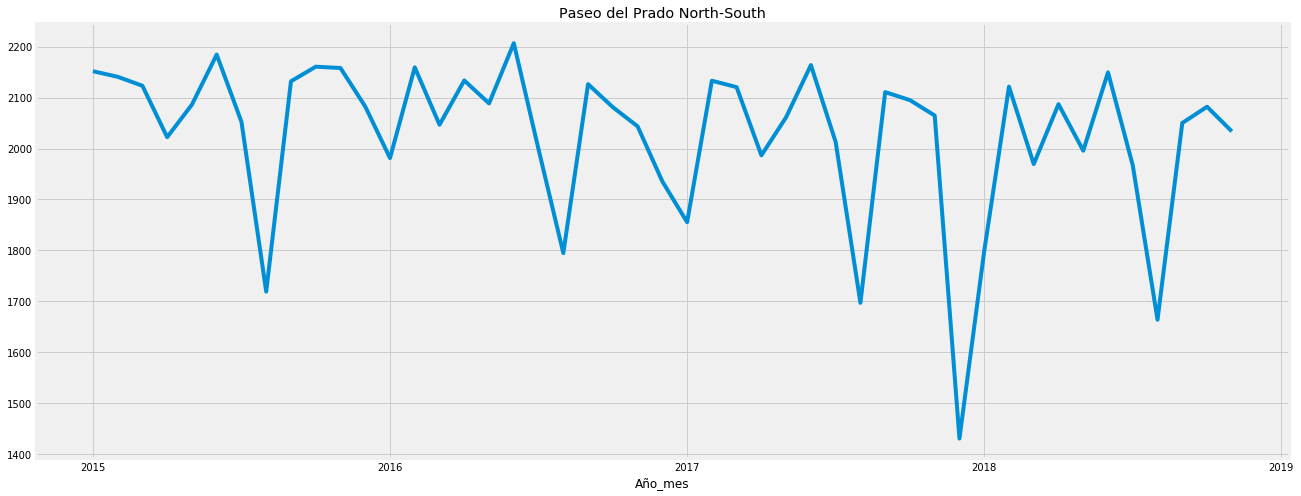

In [474]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_prado_NS_before_MC.plot()
plt.title('Paseo del Prado North-South')

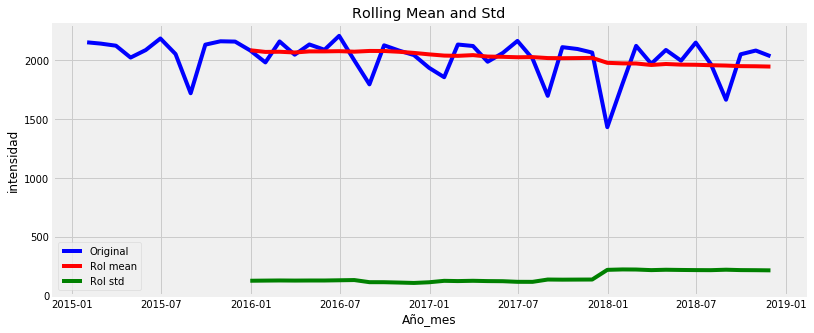

In [475]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_prado_NS = series_prado_NS_before_MC.rolling(12).mean()
rolstd_prado_NS = series_prado_NS_before_MC.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_prado_NS_before_MC, label = 'Original', color = 'blue')
plt.plot(rolmean_prado_NS, label = 'Rol mean', color = 'red')
plt.plot(rolstd_prado_NS, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

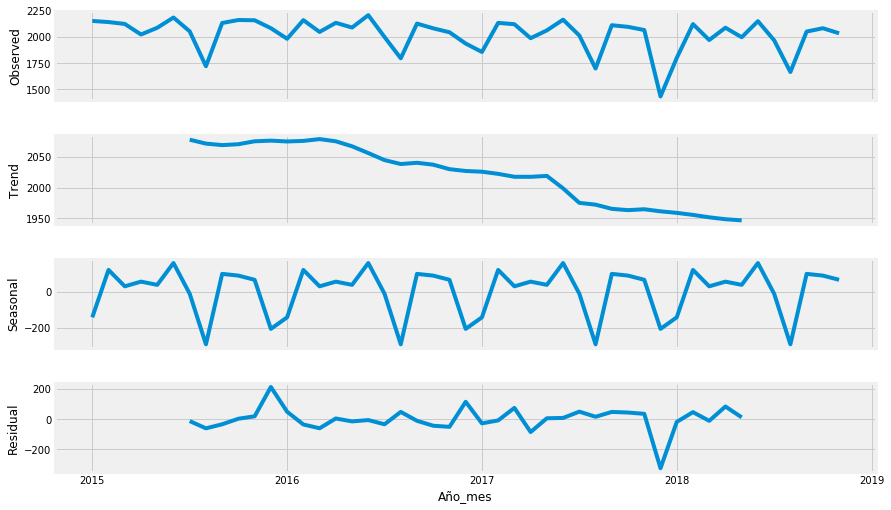

In [476]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_prado_NS_before_MC, model = 'additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [477]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

    
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_prado_NS_before_MC, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))

# Non-Stationary since the p-value > 0.05, let see the diff()

Test statistic: -1.806150764298245
p-value: 0.3774123140646095
Lag: 6
Number of observations: 40
Critical Value (1%) = -3.6055648906249997
Critical Value (5%) = -2.937069375
Critical Value (10%) = -2.606985625


In [478]:
series_prado_NS_before_MC_diff = series_prado_NS_before_MC.diff()
series_prado_NS_before_MC_diff = series_prado_NS_before_MC_diff[1:]

In [479]:
# we observe with 1 diff the serie is stationary since the p-value < 0.05

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_prado_NS_before_MC_diff, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))

Test statistic: -5.781262437773015
p-value: 5.11944342485236e-07
Lag: 10
Number of observations: 35
Critical Value (1%) = -3.6327426647230316
Critical Value (5%) = -2.9485102040816327
Critical Value (10%) = -2.6130173469387756


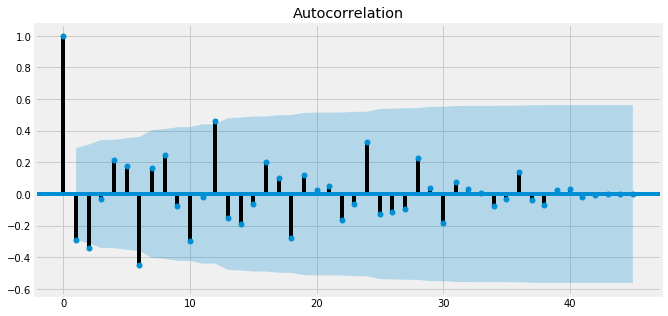

In [480]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_prado_NS_before_MC_diff)
fig.set_size_inches(10,5)

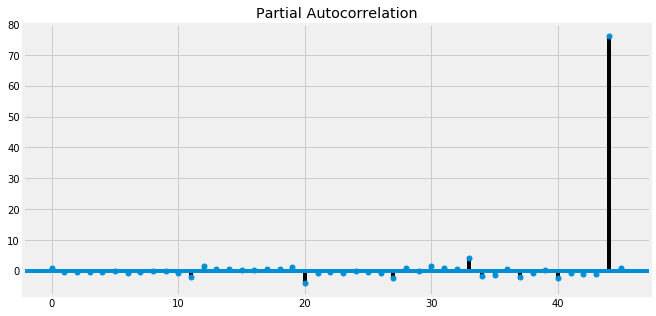

In [481]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_prado_NS_before_MC_diff)
fig.set_size_inches(10,5)

### Now it's time to build the model

In [482]:
len(series_prado_NS_before_MC)

47

In [483]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_prado_NS = series_prado_NS_before_MC.loc['2015-01-31':'2018-05-31']
test_prado_NS = series_prado_NS_before_MC.loc['2018-06-01':'2018-11-30']

In [484]:
len(train_prado_NS), len(test_prado_NS)

(41, 6)

In [485]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_prado_NS, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2018-06-30','2018-11-30')
            y_truth = test_prado_NS['2018-06-30':'2018-11-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:743.1637292857766 - p-values:sigma2    0.654324
dtype: float64
The Mean Squared Error of our forecasts is 3988393.22
The Root Mean Squared Error of our forecasts is 1997.1
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:364.1839342493039 - p-values:sigma2    1.601592e-15
dtype: float64
The Mean Squared Error of our forecasts is 1371.54
The Root Mean Squared Error of our forecasts is 37.03
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:583.0058223931267 - p-values:ar.S.L12    0.000000e+00
sigma2      6.560588e-13
dtype: float64
The Mean Squared Error of our forecasts is 1135.37
The Root Mean Squared Error of our forecasts is 33.7
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:589.1253837885525 - p-values:ar.S.L12    0.000000
ma.S.L12    0.961338
sigma2      0.960794
dtype: float64
The Mean Squared Error of our forecasts is 3218.14
The Root Mean Squared Error of our forecasts is 56.73
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:365.94374068247964 - p-values:ar.S.L12    0.726943
sigma2    

In [486]:
# The model selected in SARIMAX(1, 1, 0)x(0, 1, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05


mod = sm.tsa.statespace.SARIMAX(train_prado_NS,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -179.066
Date:                            Thu, 16 May 2019   AIC                            362.132
Time:                                    11:50:45   BIC                            364.796
Sample:                                01-31-2015   HQIC                           362.947
                                     - 05-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5448      0.132     -4.120      0.000      -0.804      -0.286
sigma2      2.102e+04   3288.421   

In [487]:
# let's have a look at the residuals in order to test their distribution and correlation

residuos = model.resid.values
residuos

array([ 2.15182553e+03,  6.33924403e+00, -2.69927707e+01, -9.62852139e+01,
        5.99264680e+01,  1.01266560e+02, -1.32057308e+02, -3.35545004e+02,
        4.08992528e+02,  3.73006565e+01, -6.70259686e+00, -7.35218617e+01,
       -1.19543780e+03,  1.54560342e+02,  7.96808460e+00,  1.36191631e+02,
       -6.65570112e+00, -3.92715633e+01, -6.57449548e+01,  8.81329108e+01,
       -1.06214439e+01, -1.18191627e+02, -7.53252899e+01, -5.15525448e+01,
        3.48684108e+00,  1.11146492e+02,  1.54449055e+02, -1.66368984e+02,
       -4.05803949e-01,  4.94049086e+01,  4.88760851e+01, -8.08993311e+01,
        2.10363617e+01,  7.42163097e+01,  2.34496908e+01, -5.22356211e+02,
        1.61394321e+02,  2.89488500e+02, -1.14854503e+02,  1.75553555e+02,
       -2.91440932e+01])

In [488]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.727 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=5.493682100970794, critical_values=array([0.532, 0.606, 0.727, 0.848, 1.009]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [489]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([ 0.05695833,  0.17011394,  0.27310085,  0.33073481,  0.83388673,
         0.84730287,  1.64424692,  2.41065158,  2.47085135,  2.47733698,
         2.48593458, 11.09066374]),
 array([0.81136967, 0.91845996, 0.96500546, 0.98774472, 0.97482178,
        0.99074495, 0.97689182, 0.96576721, 0.98165714, 0.99120187,
        0.99592828, 0.5211652 ]),
 array([0.05298449, 0.155614  , 0.24662569, 0.2962177 , 0.71746116,
        0.72838128, 1.35852309, 1.94669411, 1.99149393, 1.99616962,
        2.00216795, 7.80535738]),
 array([0.8179491 , 0.92514296, 0.96973288, 0.99005702, 0.98199664,
        0.99385796, 0.98680793, 0.98260266, 0.9916014 , 0.99636943,
        0.99848825, 0.80015007]))

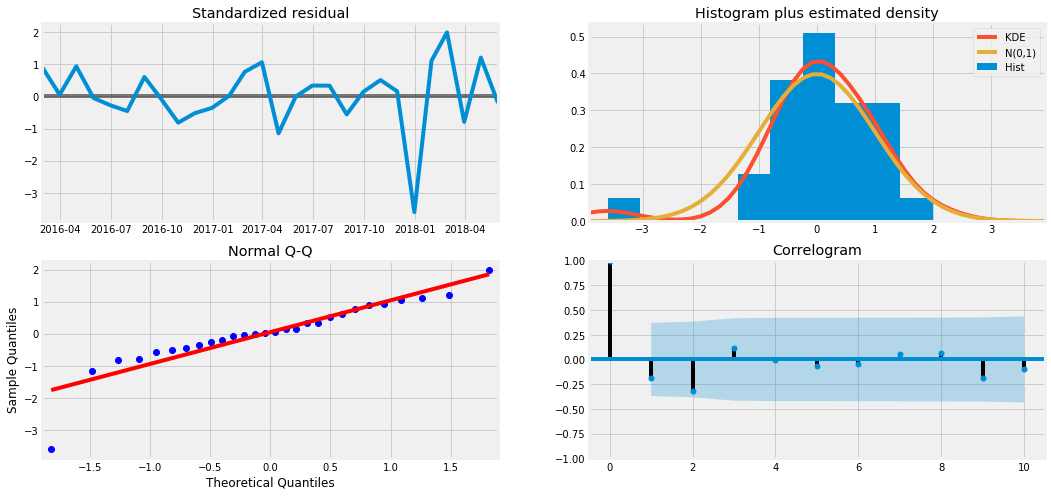

In [490]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

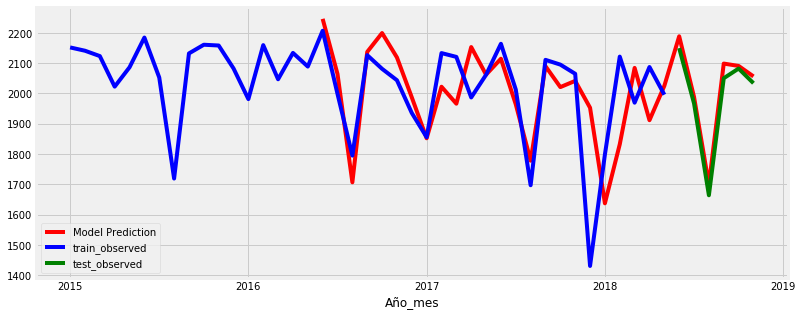

In [491]:
# Plot the model predicition vs train and test
plt.figure(figsize=(12,5))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Prediction')
train_prado_NS.plot(color = 'blue', label = 'train_observed')
test_prado_NS.plot(color = 'green', label = 'test_observed')
plt.legend()
plt.show()

In [492]:
# Prediction values for the MSE and RMSE

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_forecasted

2018-06-30    2188.594804
2018-07-31    1988.174524
2018-08-31    1699.171484
2018-09-30    2098.465875
2018-10-31    2090.683705
2018-11-30    2056.084157
Freq: M, dtype: float64

In [493]:
# test values to compare vs predicition

y_truth = test_prado_NS['2018-06-30':'2018-11-30']
y_truth

Año_mes
2018-06-30    2149.526961
2018-07-31    1966.875477
2018-08-31    1663.675059
2018-09-30    2050.082016
2018-10-31    2082.018501
2018-11-30    2033.676961
Freq: M, Name: intensidad, dtype: float64

In [494]:
# Computation of MSE and RMSE

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_truth = test_prado_NS['2018-06-30':'2018-11-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# Small RMSE so good model!

The Mean Squared Error of our forecasts is 1026.35
The Root Mean Squared Error of our forecasts is 32.04


## Applying the model

In [495]:
mod = sm.tsa.statespace.SARIMAX(series_prado_NS_before_MC,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 0, 12))
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   47
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -214.228
Date:                            Thu, 16 May 2019   AIC                            432.456
Time:                                    11:50:46   BIC                            435.509
Sample:                                01-31-2015   HQIC                           433.497
                                     - 11-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5404      0.109     -4.949      0.000      -0.754      -0.326
sigma2      1.741e+04   2223.041   

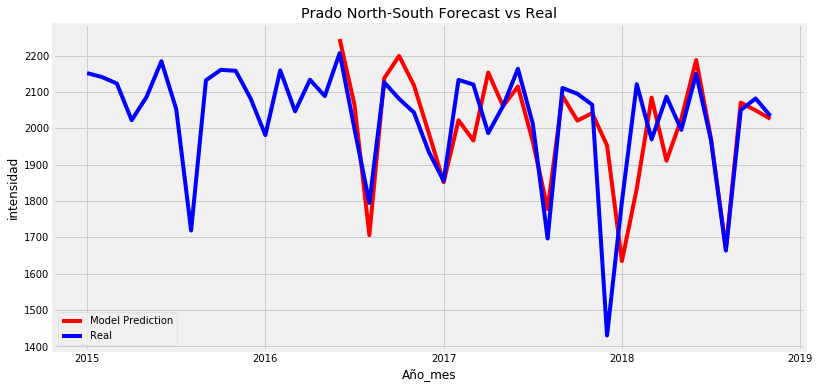

In [496]:
plt.figure(figsize=(12,6))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Prediction')
observed = series_prado_NS_before_MC.plot(color = 'blue', label = 'Real')

plt.title('Prado North-South Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

### Forecasting vs Reality Madrid Central months

In [497]:
# Now we do a time series with the months with Madrid Central to compare the prediction of the model vs the real data

prado_NS_only_MC = prado_NS_only_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
prado_NS_only_MC = prado_NS_only_MC.set_index(prado_NS_only_MC['Año_mes'])
prado_NS_only_MC.index = pd.to_datetime(prado_NS_only_MC.index)
series_prado_NS_only_MC = prado_NS_only_MC['intensidad'].resample('M').mean()

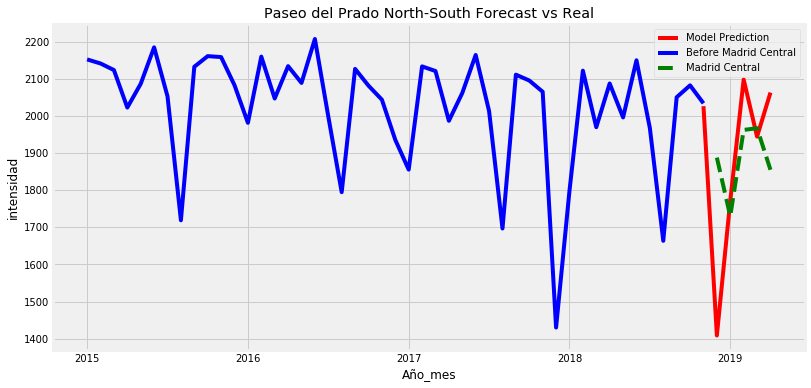

In [498]:
plt.figure(figsize=(12,6))
forecast = model.predict('2018-11-30','2019-04-30').plot(color = 'red', label='Model Prediction')
series_prado_NS_before_MC.plot(color = 'blue', label='Before Madrid Central')
series_prado_NS_only_MC.plot(linestyle='dashed', color = 'green', label = 'Madrid Central')

plt.title('Paseo del Prado North-South Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

#### Real figures higher than expected at the beginning but higher afterwards we observe clearly the the traffic intensity is lower

### Let's see numerical values

In [257]:
#### Real figures lower than expected at the beginning but higher afterwards

### Let's see numerical values# Comparing the forecasted vs real on December 2018 and see the differences

y_forecasted_Dec18 = model.predict('2018-12-31')
y_truth_Dec18 = series_prado_NS_only_MC['2018-12-31']
y_forecasted_Dec18, y_truth_Dec18
print('On December it was expected an average of %.i intensity and the result was %.i' % (y_forecasted_Dec18, y_truth_Dec18))

On December it was expected an average of 1408 intensity and the result was 1887


In [258]:
# Here I compare the results of all the months of December of my dataset
# Historically the intensity has been reducing. Despite Dec 2018 was higher than Dec 2017, the trend is going down

y_truth_Dec15 = series_prado_NS_before_MC['2015-12-31']
y_truth_Dec16 = series_prado_NS_before_MC['2016-12-31']
y_truth_Dec17 = series_prado_NS_before_MC['2017-12-31']
y_truth_Dec18 = series_prado_NS_only_MC['2018-12-31']

y_truth_Dec15, y_truth_Dec16, y_truth_Dec17, y_truth_Dec18

(2082.451862602806, 1935.378557874763, 1430.2799760191847, 1887.6024667931688)

In [259]:
# Comparing the forecasted vs real on January 2019 and see the differences

y_forecasted_Jan19 = model.predict('2019-01-31')
y_truth_Jan19 = series_prado_NS_only_MC['2019-01-31']
y_forecasted_Jan19, y_truth_Jan19
print('On January it was expected an average of %.i intensity and the result was %.i' % (y_forecasted_Jan19, y_truth_Jan19))

On January it was expected an average of 1771 intensity and the result was 1730


In [260]:
# Here I compare the results of all the months of December of my dataset
# We observe a general decreasing trend

y_truth_Jan16 = series_prado_NS_before_MC['2016-01-31']
y_truth_Jan17 = series_prado_NS_before_MC['2017-01-31']
y_truth_Jan18 = series_prado_NS_before_MC['2018-01-31']
y_truth_Jan19 = series_prado_NS_only_MC['2019-01-31']

y_truth_Jan16, y_truth_Jan17, y_truth_Jan18, y_truth_Jan19

(1981.1940227703985,
 1855.2763744427934,
 1798.3570029382959,
 1730.0014231499051)

In [261]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_Feb19 = model.predict('2019-02-28')
y_truth_Feb19 = series_prado_NS_only_MC['2019-02-28']
y_forecasted_Feb19, y_truth_Feb19
print('On February it was expected an average of %.i intensity and the result was %.i' % (y_forecasted_Feb19, y_truth_Feb19))

On February it was expected an average of 2097 intensity and the result was 1962


In [262]:
# Here I compare the results of all the months of February of my dataset
# We observe a general decreasing trend

y_truth_Feb15 = series_prado_NS_before_MC['2015-02-28']
y_truth_Feb16 = series_prado_NS_before_MC['2016-02-29']
y_truth_Feb17 = series_prado_NS_before_MC['2017-02-28']
y_truth_Feb18 = series_prado_NS_before_MC['2018-02-28']
y_truth_Feb19 = series_prado_NS_only_MC['2019-02-28']

y_truth_Feb15, y_truth_Feb16, y_truth_Feb17, y_truth_Feb18, y_truth_Feb19

(2140.9038865546217,
 2159.404615384615,
 2133.1076680672268,
 2121.504741833509,
 1962.0994736842106)

In [263]:
# Comparing the forecasted vs real on March 2019 and see the differences

y_forecasted_March19 = model.predict('2019-03-31')
y_truth_March19 = series_prado_NS_only_MC['2019-03-31']
y_forecasted_March19, y_truth_March19
print('On March it was expected an average of %.i intensity and the result was %.i' % (y_forecasted_March19, y_truth_March19))

On March it was expected an average of 1944 intensity and the result was 1966


In [264]:
# Here I compare the results of all the months of March of my dataset
# We observe a general decreasing trend and the last observation of March does not vary a lot from 2018.

y_truth_March15 = series_prado_NS_before_MC['2015-03-31']
y_truth_March16 = series_prado_NS_before_MC['2016-03-31']
y_truth_March17 = series_prado_NS_before_MC['2017-03-31']
y_truth_March18 = series_prado_NS_before_MC['2018-03-31']
y_truth_March19 = series_prado_NS_only_MC['2019-03-31']

y_truth_March15, y_truth_March16, y_truth_March17, y_truth_March18, y_truth_March19

(2123.2152019002374,
 2046.643076923077,
 2120.5209324452903,
 1969.3746970431412,
 1966.7513278609367)

In [265]:
# Comparing the forecasted vs real on April 2019 and see the differences

y_forecasted_Apr19 = model.predict('2019-04-30')
y_truth_Apr19 = series_prado_NS_only_MC['2019-04-30']
y_forecasted_Apr19, y_truth_Apr19
print('On April it was expected an average of %.i intensity and the result was %.i' % (y_forecasted_Apr19, y_truth_Apr19))

On April it was expected an average of 2062 intensity and the result was 1854


In [266]:
# Here I compare the results of all the months of April of my dataset
# Ups&downs in the trend. This year easter was also in April so it may impact.

y_truth_Apr15 = series_prado_NS_before_MC['2015-04-30']
y_truth_Apr16 = series_prado_NS_before_MC['2016-04-30']
y_truth_Apr17 = series_prado_NS_before_MC['2017-04-30']
y_truth_Apr18 = series_prado_NS_before_MC['2018-04-30']
y_truth_Apr19 = series_prado_NS_only_MC['2019-04-30']

y_truth_Apr15, y_truth_Apr16, y_truth_Apr17, y_truth_Apr18, y_truth_Apr19

(2022.2837232453958,
 2133.699772554966,
 1986.632512315271,
 2087.064278704612,
 1854.8374809547995)

## Focus on RONDA VALENCIA West-East

In [447]:
# Split the information of each devices in:
    # Full dataset
    # Observations before Madrid Central (with the suffix "before_MC")
    # Observations since the beggining of Madrid Central (with the suffix "only_MC")

valencia_WE = final_data[final_data['id'] == 4211]
valencia_WE_before_MC = data_before_MC[data_before_MC['id'] == 4211]
valencia_WE_only_MC = data_only_MC[data_only_MC['id'] == 4211]

In [448]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

valencia_WE_before_MC = valencia_WE_before_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
valencia_WE_before_MC = valencia_WE_before_MC.set_index(valencia_WE_before_MC['Año_mes'])
valencia_WE_before_MC.index = pd.to_datetime(valencia_WE_before_MC.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_valencia_WE_before_MC = valencia_WE_before_MC['intensidad'].resample('M').mean()

Text(0.5, 1.0, 'Ronda de Valencia West-East')

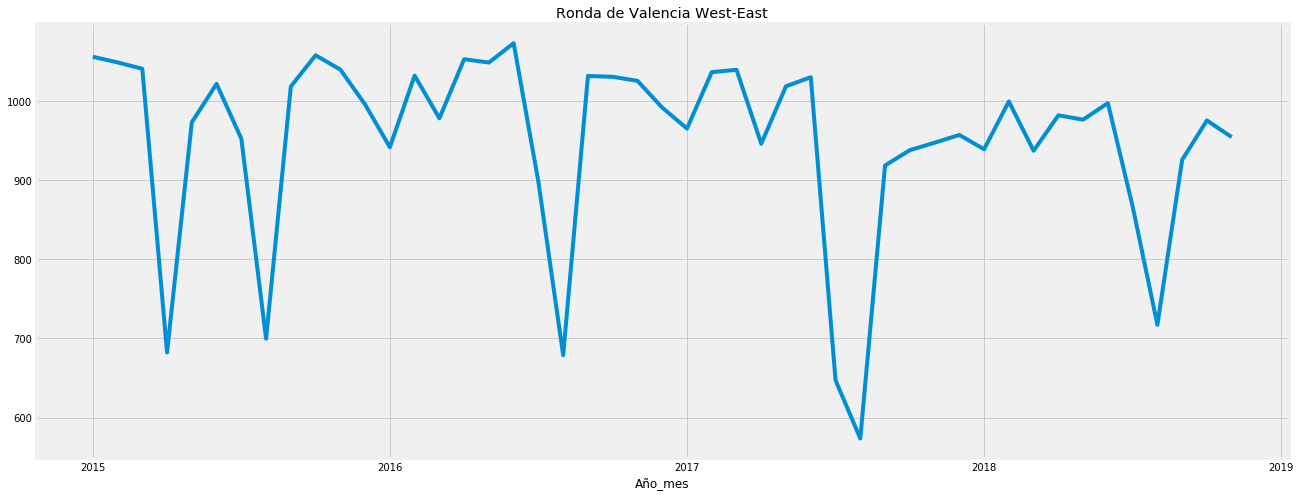

In [449]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_valencia_WE_before_MC.plot()
plt.title('Ronda de Valencia West-East')

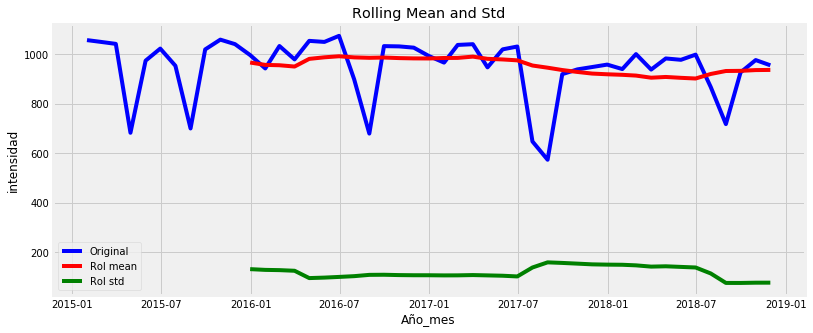

In [450]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_valencia_WE = series_valencia_WE_before_MC.rolling(12).mean()
rolstd_valencia_WE = series_valencia_WE_before_MC.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_valencia_WE_before_MC, label = 'Original', color = 'blue')
plt.plot(rolmean_valencia_WE, label = 'Rol mean', color = 'red')
plt.plot(rolstd_valencia_WE, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

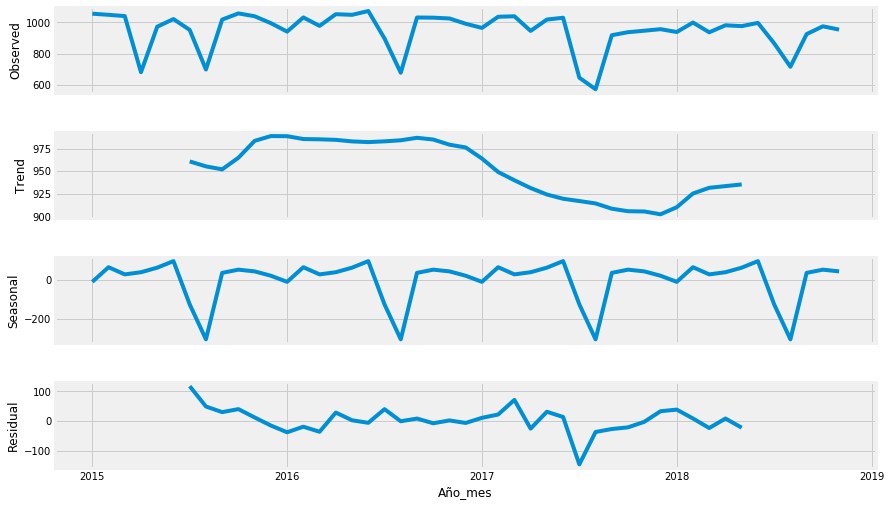

In [451]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_valencia_WE_before_MC, model = 'additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [452]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_valencia_WE_before_MC, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))

# Stationary since the p-value < 0.05

Test statistic: -5.415967213562541
p-value: 3.135224604821034e-06
Lag: 1
Number of observations: 45
Critical Value (1%) = -3.584828853223594
Critical Value (5%) = -2.9282991495198907
Critical Value (10%) = -2.6023438271604937


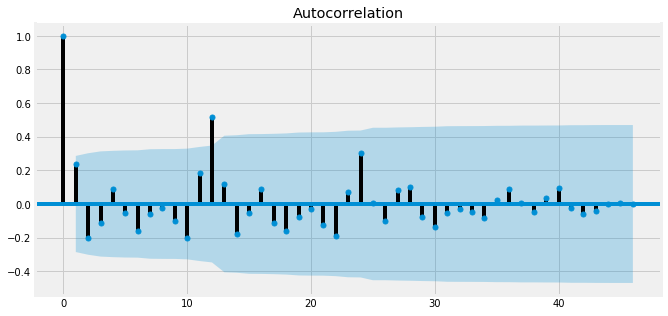

In [453]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_valencia_WE_before_MC)
fig.set_size_inches(10,5)

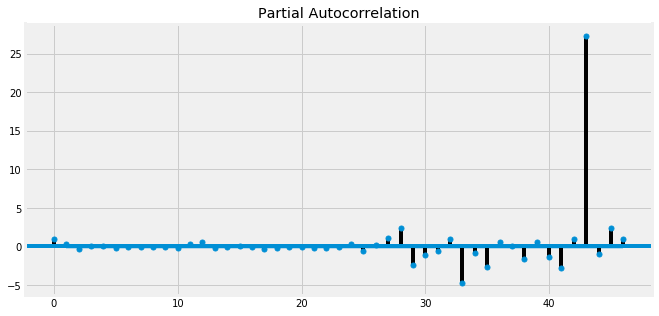

In [454]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_valencia_WE_before_MC)
fig.set_size_inches(10,5)

### Now it's time to build the model

In [455]:
len(series_valencia_WE_before_MC)

47

In [456]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_valencia_WE = series_valencia_WE_before_MC.loc['2015-01-31':'2018-05-31']
test_valencia_WE = series_valencia_WE_before_MC.loc['2018-06-01':'2018-11-30']

In [457]:
len(train_valencia_WE), len(test_valencia_WE)

(41, 6)

In [458]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_valencia_WE, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2018-06-30','2018-11-30')
            y_truth = test_valencia_WE['2018-06-30':'2018-11-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:681.8025954803865 - p-values:sigma2    0.480366
dtype: float64
The Mean Squared Error of our forecasts is 829977.21
The Root Mean Squared Error of our forecasts is 911.03
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:352.77842519507186 - p-values:sigma2    8.677113e-12
dtype: float64
The Mean Squared Error of our forecasts is 11907.79
The Root Mean Squared Error of our forecasts is 109.12
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:553.1644887188473 - p-values:ar.S.L12    0.000000e+00
sigma2      1.457316e-11
dtype: float64
The Mean Squared Error of our forecasts is 12401.88
The Root Mean Squared Error of our forecasts is 111.36
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:566.5152843869743 - p-values:ar.S.L12    5.459590e-235
ma.S.L12     9.887398e-01
sigma2       9.887026e-01
dtype: float64
The Mean Squared Error of our forecasts is 34747.33
The Root Mean Squared Error of our forecasts is 186.41
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:353.6040923946247 - p-values:ar.S.L12  

ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:344.80788517162864 - p-values:ar.L1       0.485839
ma.L1       0.969642
ar.S.L12    0.101710
sigma2      0.969351
dtype: float64
The Mean Squared Error of our forecasts is 7445.5
The Root Mean Squared Error of our forecasts is 86.29


In [459]:
# The model selected in SARIMAX(0, 1, 0)x(1, 0, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05


mod = sm.tsa.statespace.SARIMAX(train_valencia_WE,
                                order=(0, 1, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   41
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -250.648
Date:                            Thu, 16 May 2019   AIC                            505.295
Time:                                    11:49:44   BIC                            508.673
Sample:                                01-31-2015   HQIC                           506.517
                                     - 05-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.6696      0.073      9.118      0.000       0.526       0.814
sigma2      1.355e+04   2471.518   

In [460]:
# let's have a look at the residuals in order to test their distribution and correlation

residuos = model.resid.values
residuos

array([ 1.05595695e+03, -7.08859688e+00, -8.10106252e+00, -3.58435192e+02,
        2.90749441e+02,  4.86245505e+01, -6.92717456e+01, -2.52847775e+02,
        3.18853125e+02,  3.93981309e+01, -1.80997669e+01, -4.41396059e+01,
       -7.08900042e+01,  9.52285394e+01, -4.85243834e+01,  3.14712826e+02,
       -1.98914599e+02, -8.11156878e+00, -1.29039625e+02, -4.93990680e+01,
        1.39225461e+02, -2.74719992e+01,  7.03804644e+00, -4.26301697e+00,
        9.63324115e+00,  1.07086817e+01,  3.91092327e+01, -1.43468723e+02,
        7.54553088e+01, -4.98248331e+00, -2.65411400e+02,  7.27763276e+01,
        1.08869377e+02,  2.00565267e+01,  1.28021730e+01,  3.25030504e+01,
       -3.49789727e-01,  1.26792792e+01, -6.43405670e+01,  1.07352822e+02,
       -5.40646864e+01])

In [461]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.727 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=3.0760586640418452, critical_values=array([0.532, 0.606, 0.727, 0.848, 1.009]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [462]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([ 1.00596498,  1.10774023,  4.11423236,  6.81336058,  6.81693207,
         7.05212424,  7.5437577 ,  8.20444228,  8.38456202,  8.64485686,
         9.04964951, 10.00329607]),
 array([0.31587145, 0.57472126, 0.24939037, 0.14608617, 0.23461521,
        0.31605369, 0.37453609, 0.41375883, 0.49590361, 0.56610651,
        0.61730934, 0.61567148]),
 array([0.93578138, 1.02808916, 3.68498919, 6.00749486, 6.01048495,
        6.20192043, 6.59065387, 7.09769087, 7.23173347, 7.41938789,
        7.70180136, 8.34495834]),
 array([0.33336513, 0.59807173, 0.29755022, 0.19858925, 0.30520002,
        0.40095533, 0.47270643, 0.52613024, 0.61300654, 0.68534707,
        0.73974078, 0.75762556]))

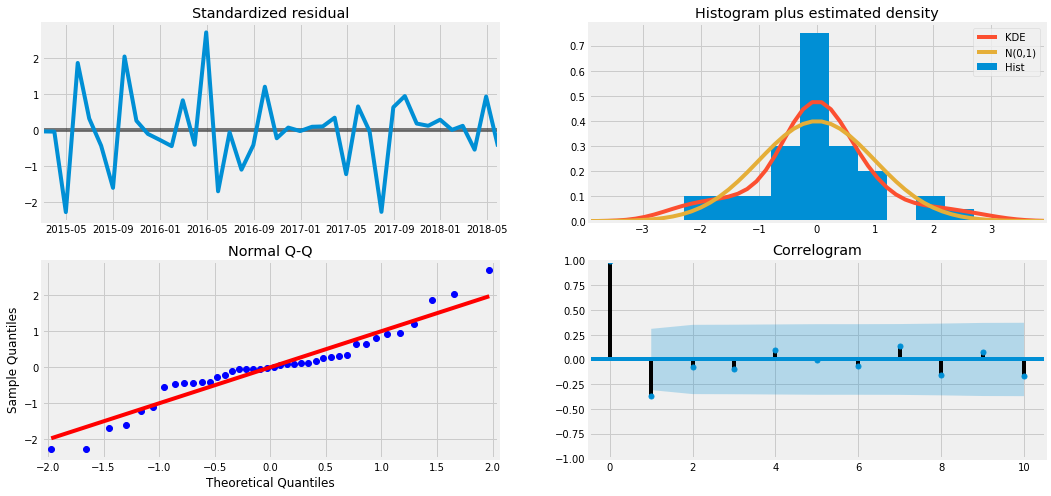

In [463]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

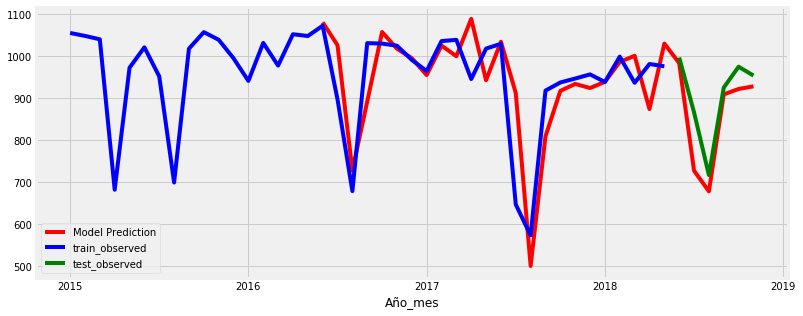

In [464]:
# Plot the model predicition vs train and test
plt.figure(figsize=(12,5))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Prediction')
train_valencia_WE.plot(color = 'blue', label = 'train_observed')
test_valencia_WE.plot(color = 'green', label = 'test_observed')
plt.legend()
plt.show()

In [465]:
# Numeric figures of the prediction of my model

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_forecasted

2018-06-30    984.147481
2018-07-31    727.757061
2018-08-31    678.417442
2018-09-30    909.490980
2018-10-31    922.432828
2018-11-30    928.726707
Freq: M, dtype: float64

In [466]:
# real figures of the test to compare vs prediction

y_truth = test_valencia_WE['2018-06-30':'2018-11-30']
y_truth

Año_mes
2018-06-30    997.368627
2018-07-31    866.789499
2018-08-31    717.215370
2018-09-30    925.695588
2018-10-31    975.490692
2018-11-30    954.412255
Freq: M, Name: intensidad, dtype: float64

In [467]:
# Computation of MSE and RMSE

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_truth = test_valencia_WE['2018-06-30':'2018-11-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 4124.6
The Root Mean Squared Error of our forecasts is 64.22


## Applying the model

In [468]:
mod = sm.tsa.statespace.SARIMAX(series_valencia_WE_before_MC,
                                order=(0, 1, 0),
                                seasonal_order=(1, 0, 0, 12))
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   47
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -285.639
Date:                            Thu, 16 May 2019   AIC                            575.278
Time:                                    11:49:46   BIC                            578.935
Sample:                                01-31-2015   HQIC                           576.648
                                     - 11-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.6406      0.068      9.434      0.000       0.508       0.774
sigma2       1.26e+04   2104.238   

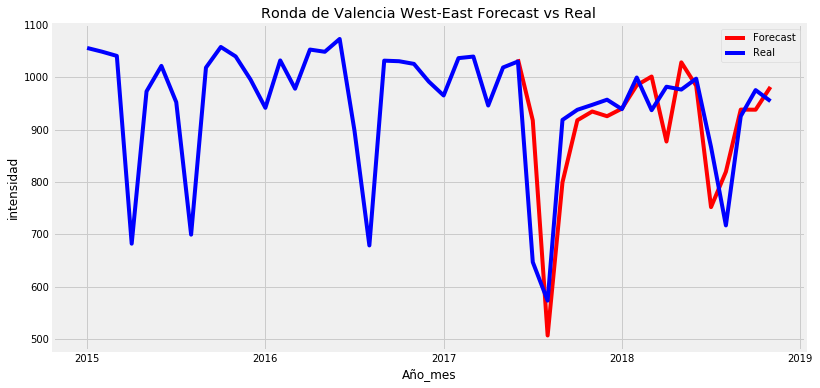

In [469]:
plt.figure(figsize=(12,6))
forecast = model.predict('2017-06-30','2018-11-30').plot(color = 'red', label = 'Forecast')
observed = series_valencia_WE_before_MC.plot(color = 'blue', label = 'Real')

plt.title('Ronda de Valencia West-East Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

### Forecasting vs Reality Madrid Central months

In [470]:
# Now we do a time series with the months with Madrid Central to compare the prediction of the model vs the real data

valencia_WE_only_MC = valencia_WE_only_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
valencia_WE_only_MC = valencia_WE_only_MC.set_index(valencia_WE_only_MC['Año_mes'])
valencia_WE_only_MC.index = pd.to_datetime(valencia_WE_only_MC.index)
series_valencia_WE_only_MC = valencia_WE_only_MC['intensidad'].resample('M').mean()

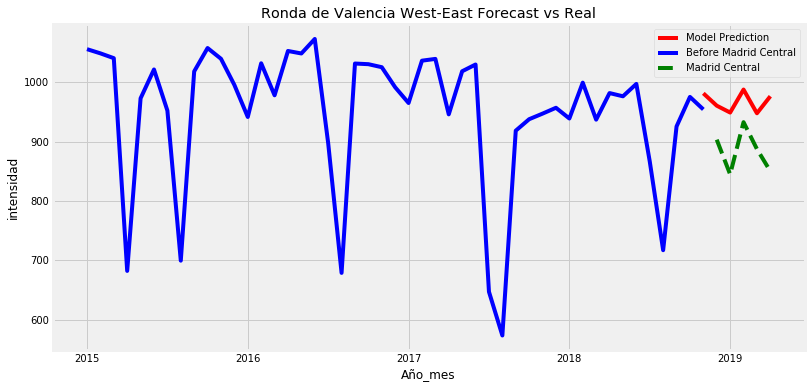

In [471]:
plt.figure(figsize=(12,6))
forecast = model.predict('2018-11-30','2019-04-30').plot(color = 'red', label='Model Prediction')
series_valencia_WE_before_MC.plot(color = 'blue', label='Before Madrid Central')
series_valencia_WE_only_MC.plot(linestyle='dashed', color = 'green', label = 'Madrid Central')

plt.title('Ronda de Valencia West-East Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

#### We appreciate the reality was indeed much lower than expected so the impact is clear. If we see the historical trend after an increase is to be stable for a while and here there is a big drop

### Let's see numerical values

In [293]:
#Comparing the forecasted vs real on December 2018 and see the differences

y_forecasted_Dec18 = model.predict('2018-12-31')
y_truth_Dec18 = series_valencia_WE_only_MC['2018-12-31']
y_forecasted_Dec18, y_truth_Dec18
print('On December it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Dec18, y_truth_Dec18))

On December it was expected an average of 960 intensity and the result was 903


In [294]:
# Here I compare the results of all the months of December of my dataset
# General trend to reduce the intensitiy with a big drop on 2019 as the chart displays

y_truth_Dec15 = series_valencia_WE_before_MC['2015-12-31']
y_truth_Dec16 = series_valencia_WE_before_MC['2016-12-31']
y_truth_Dec17 = series_valencia_WE_before_MC['2017-12-31']
y_truth_Dec18 = series_valencia_WE_only_MC['2018-12-31']

y_truth_Dec15, y_truth_Dec16, y_truth_Dec17, y_truth_Dec18

(995.5984518626028, 991.7239089184061, 957.1807036247335, 903.4169829222011)

In [295]:
# Comparing the forecasted vs real on January 2019 and see the differences

y_forecasted_Jan19 = model.predict('2019-01-31')
y_truth_Jan19 = series_valencia_WE_only_MC['2019-01-31']
y_forecasted_Jan19, y_truth_Jan19
print('On January it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Jan19, y_truth_Jan19))

On January it was expected an average of 949 intensity and the result was 844


In [296]:
# Here I compare the results of all the months of January of my dataset
# General trend to reduce the intensitiy with a big drop on 2019 as the chart displays

y_truth_Jan16 = series_valencia_WE_before_MC['2016-01-31']
y_truth_Jan17 = series_valencia_WE_before_MC['2017-01-31']
y_truth_Jan18 = series_valencia_WE_before_MC['2018-01-31']
y_truth_Jan19 = series_valencia_WE_only_MC['2019-01-31']

y_truth_Jan16, y_truth_Jan17, y_truth_Jan18, y_truth_Jan19

(941.6612903225806, 965.2390891840607, 939.095825426945, 844.9966714217784)

In [297]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_Feb19 = model.predict('2019-02-28')
y_truth_Feb19 = series_valencia_WE_only_MC['2019-02-28']
y_forecasted_Feb19, y_truth_Feb19
print('On February it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Feb19, y_truth_Feb19))

On February it was expected an average of 987 intensity and the result was 932


In [298]:
# Here I compare the results of all the months of February of my dataset
# General trend to reduce the intensitiy (except 20) with a big drop on 2019 as the chart displays

y_truth_Feb15 = series_valencia_WE_before_MC['2015-02-28']
y_truth_Feb16 = series_valencia_WE_before_MC['2016-02-29']
y_truth_Feb17 = series_valencia_WE_before_MC['2017-02-28']
y_truth_Feb18 = series_valencia_WE_before_MC['2018-02-28']
y_truth_Feb19 = series_valencia_WE_only_MC['2019-02-28']

y_truth_Feb15, y_truth_Feb16, y_truth_Feb17, y_truth_Feb18, y_truth_Feb19

(1048.8683517640864,
 1032.143076923077,
 1036.5372899159663,
 999.5186766275347,
 932.9279705573081)

In [299]:
# Comparing the forecasted vs real on March 2019 and see the differences

y_forecasted_March19 = model.predict('2019-03-31')
y_truth_March19 = series_valencia_WE_only_MC['2019-03-31']
y_forecasted_March19, y_truth_March19
print('On March it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_March19, y_truth_March19))

On March it was expected an average of 947 intensity and the result was 887


In [300]:
# Here I compare the results of all the months of March of my dataset
# Historically ups&downs and huge drop on March 2019

y_truth_March15 = series_valencia_WE_before_MC['2015-03-31']
y_truth_March16 = series_valencia_WE_before_MC['2016-03-31']
y_truth_March17 = series_valencia_WE_before_MC['2017-03-31']
y_truth_March18 = series_valencia_WE_before_MC['2018-03-31']
y_truth_March19 = series_valencia_WE_only_MC['2019-03-31']

y_truth_March15, y_truth_March16, y_truth_March17, y_truth_March18, y_truth_March19

(1040.7672892478547,
 978.1939611054248,
 1039.5204567078972,
 937.1757342320655,
 887.5837708830549)

In [301]:
# Comparing the forecasted vs real on April 2019 and see the differences

y_forecasted_Apr19 = model.predict('2019-04-30')
y_truth_Apr19 = series_valencia_WE_only_MC['2019-04-30']
y_forecasted_Apr19, y_truth_Apr19
print('On April it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Apr19, y_truth_Apr19))

On April it was expected an average of 976 intensity and the result was 850


In [302]:
# Here I compare the results of all the months of March of my dataset
# Ups&downs but a huge drop on April 2019

y_truth_Apr15 = series_valencia_WE_before_MC['2015-04-30']
y_truth_Apr16 = series_valencia_WE_before_MC['2016-04-30']
y_truth_Apr17 = series_valencia_WE_before_MC['2017-04-30']
y_truth_Apr18 = series_valencia_WE_before_MC['2018-04-30']
y_truth_Apr19 = series_valencia_WE_only_MC['2019-04-30']

y_truth_Apr15, y_truth_Apr16, y_truth_Apr17, y_truth_Apr18, y_truth_Apr19

(682.3320974576271,
 1052.8870356330553,
 946.0686225758329,
 981.9501972386588,
 850.2817109144543)

## Focus on ALBERTO AGUILERA West-East

In [303]:
# Split the information of each devices in:
    # Full dataset
    # Observations before Madrid Central (with the suffix "before_MC")
    # Observations since the beggining of Madrid Central (with the suffix "only_MC")
aguilera_WE = final_data[final_data['id'] == 4386]
aguilera_WE_before_MC = data_before_MC[data_before_MC['id'] == 4386]
aguilera_WE_only_MC = data_only_MC[data_only_MC['id'] == 4386]

In [304]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

aguilera_WE_before_MC = aguilera_WE_before_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
aguilera_WE_before_MC = aguilera_WE_before_MC.set_index(aguilera_WE_before_MC['Año_mes'])
aguilera_WE_before_MC.index = pd.to_datetime(aguilera_WE_before_MC.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_aguilera_WE_before_MC = aguilera_WE_before_MC['intensidad'].resample('M').mean()

Text(0.5, 1.0, 'Alberto Aguilera East-West')

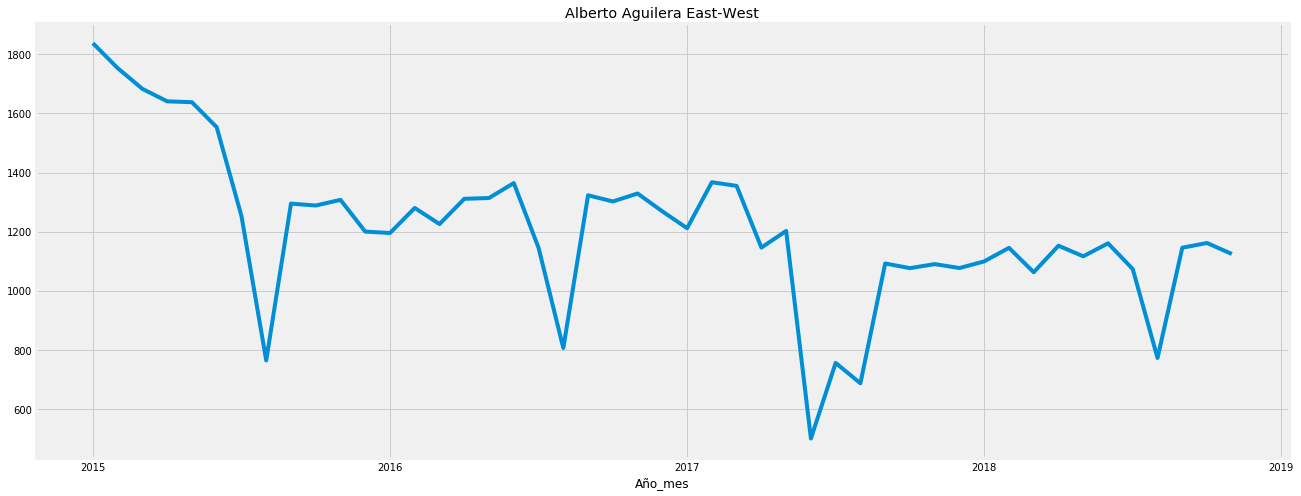

In [305]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_aguilera_WE_before_MC.plot()
plt.title('Alberto Aguilera East-West')

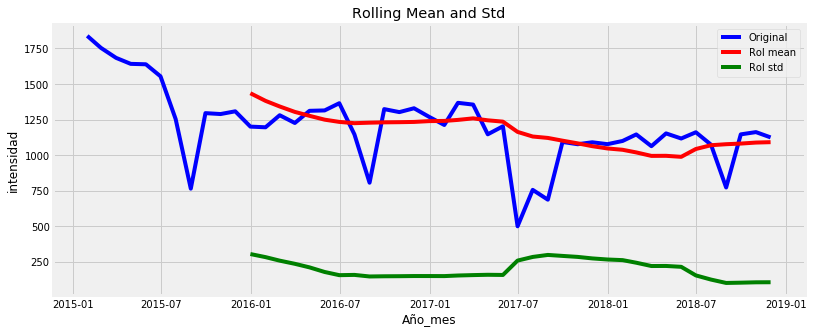

In [306]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_aguilera_WE = series_aguilera_WE_before_MC.rolling(12).mean()
rolstd_aguilera_WE = series_aguilera_WE_before_MC.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_aguilera_WE_before_MC, label = 'Original', color = 'blue')
plt.plot(rolmean_aguilera_WE, label = 'Rol mean', color = 'red')
plt.plot(rolstd_aguilera_WE, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

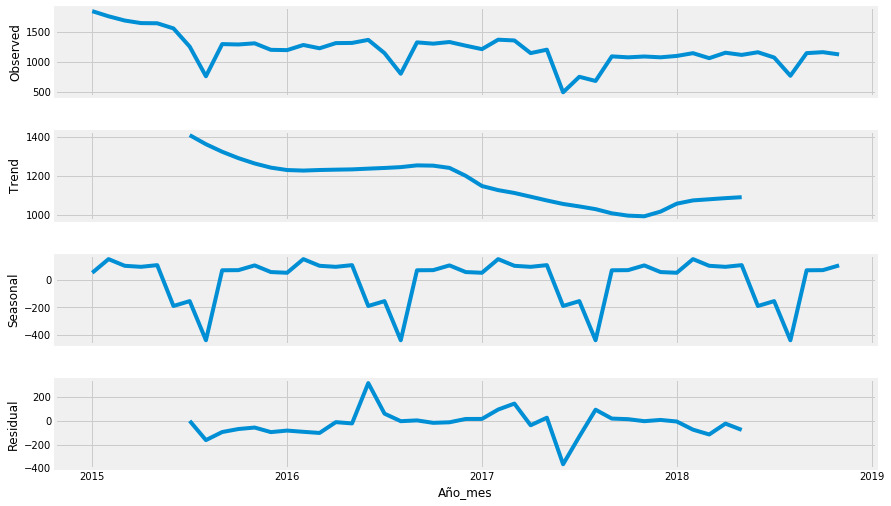

In [307]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_aguilera_WE_before_MC, model = 'additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [308]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_aguilera_WE_before_MC, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))

# Stationary since the p-value < 0.05

Test statistic: -3.6587752503812787
p-value: 0.00473183475030172
Lag: 0
Number of observations: 46
Critical Value (1%) = -3.5812576580093696
Critical Value (5%) = -2.9267849124681518
Critical Value (10%) = -2.6015409829867675


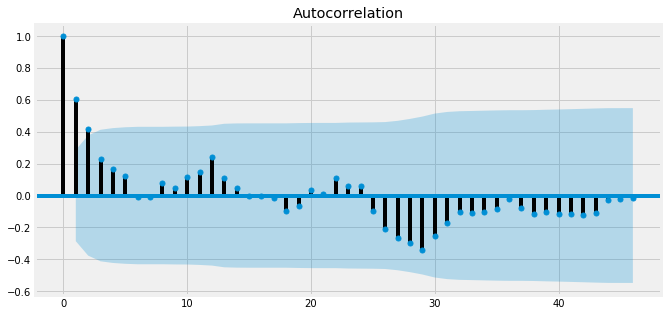

In [310]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_aguilera_WE_before_MC)
fig.set_size_inches(10,5)

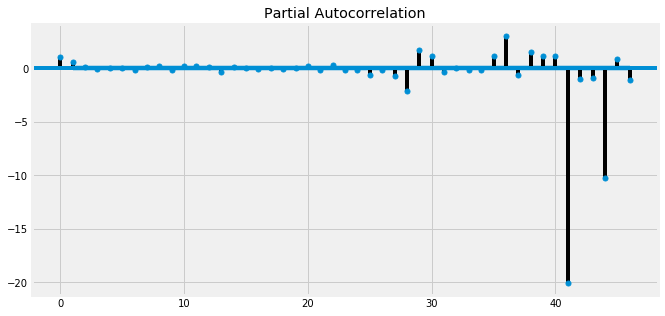

In [311]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_aguilera_WE_before_MC)
fig.set_size_inches(10,5)

### Now it's time to build the model

In [312]:
len(series_aguilera_WE_before_MC)

47

In [313]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_aguilera_WE = series_aguilera_WE_before_MC.loc['2015-01-31':'2018-05-31']
test_aguilera_WE = series_aguilera_WE_before_MC.loc['2018-06-01':'2018-11-30']

In [314]:
len(train_aguilera_WE), len(test_aguilera_WE)

(41, 6)

In [315]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most


p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_aguilera_WE, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2018-06-30','2018-11-30')
            y_truth = test_aguilera_WE['2018-06-30':'2018-11-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:703.3760613799329 - p-values:sigma2    0.178632
dtype: float64
The Mean Squared Error of our forecasts is 1169887.69
The Root Mean Squared Error of our forecasts is 1081.61
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:413.2558525660628 - p-values:sigma2    8.438550e-07
dtype: float64
The Mean Squared Error of our forecasts is 92714.25
The Root Mean Squared Error of our forecasts is 304.49
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:620.1956211916713 - p-values:ar.S.L12    0.000000
sigma2      0.000005
dtype: float64
The Mean Squared Error of our forecasts is 100557.78
The Root Mean Squared Error of our forecasts is 317.11
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:628.4104104572059 - p-values:ar.S.L12    2.371015e-68
ma.S.L12    1.214625e-03
sigma2      0.000000e+00
dtype: float64
The Mean Squared Error of our forecasts is 317392.86
The Root Mean Squared Error of our forecasts is 563.38
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:414.81424385986793 - p-values:ar.S.L12    5.729

ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:539.7386224940426 - p-values:ar.L1       4.043028e-02
ma.L1       8.035417e-06
ar.S.L12    1.329683e-03
sigma2      4.108735e-18
dtype: float64
The Mean Squared Error of our forecasts is 51743.38
The Root Mean Squared Error of our forecasts is 227.47
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:381.49189359902545 - p-values:ar.L1       0.013144
ma.L1       0.872022
ar.S.L12    0.549397
sigma2      0.871325
dtype: float64
The Mean Squared Error of our forecasts is 121543.46
The Root Mean Squared Error of our forecasts is 348.63


In [382]:
# The model selectede is SARIMAX(0, 1, 1)x(0, 0, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05


mod = sm.tsa.statespace.SARIMAX(train_aguilera_WE,
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             intensidad   No. Observations:                   41
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -270.565
Date:                Thu, 16 May 2019   AIC                            545.130
Time:                        00:34:25   BIC                            548.507
Sample:                    01-31-2015   HQIC                           546.351
                         - 05-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3441      0.116     -2.960      0.003      -0.572      -0.116
sigma2      4.392e+04   6300.374      6.970      0.000    3.16e+04    5.63e+04
Ljung-Box (Q):                       31.27   Jarque-

In [383]:
# let's have a look at the residuals in order to test their distribution and correlation

residuos = model.resid.values
residuos

array([1837.89894419,  -57.93052194,  -88.12659327,  -72.15562849,
        -27.76431886,  -94.16649516, -332.85415467, -603.64735   ,
        323.12036968,  104.78153429,   55.24999041,  -88.54501236,
        -35.14336858,   72.64375216,  -29.54737782,   75.3222153 ,
         28.71646809,   60.49456004, -198.1619036 , -407.88170628,
        376.95384428,  108.6361804 ,   64.42562711,  -38.31792268,
        -70.22593871,  131.51511885,   32.88329822, -197.542627  ,
        -11.55130012, -706.86399416,   12.76897884,  -64.59413618,
        383.40344444,  116.13565957,   53.61056798,    5.12168532,
         24.29310232,   54.24896535,  -63.93629186,   67.82936869,
        -12.51025598])

In [384]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.727 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=4.130905910251457, critical_values=array([0.532, 0.606, 0.727, 0.848, 1.009]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [385]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([1.25165900e-03, 5.89489033e-02, 5.69018424e-01, 5.90955655e-01,
        5.91287578e-01, 1.59971288e+00, 4.21834617e+00, 4.76721262e+00,
        4.78262225e+00, 4.88015109e+00, 4.88114391e+00, 5.45698723e+00]),
 array([0.97177769, 0.97095568, 0.9034868 , 0.9640634 , 0.98839867,
        0.95259804, 0.75431278, 0.78214233, 0.85283096, 0.8990388 ,
        0.93678564, 0.94095077]),
 array([1.16433395e-03, 5.34943928e-02, 5.04253504e-01, 5.23129726e-01,
        5.23407615e-01, 1.34421891e+00, 3.41476616e+00, 3.83598925e+00,
        3.84745688e+00, 3.91776837e+00, 3.91846103e+00, 4.30682049e+00]),
 array([0.9727796 , 0.97360734, 0.91795595, 0.97121059, 0.99124111,
        0.96916353, 0.84416919, 0.87160951, 0.92116247, 0.95098035,
        0.97224174, 0.97724204]))

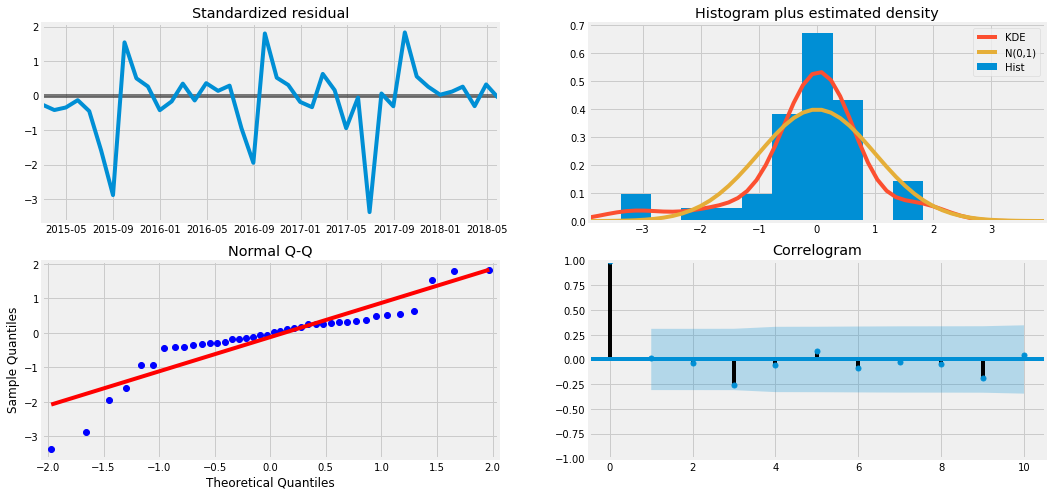

In [386]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

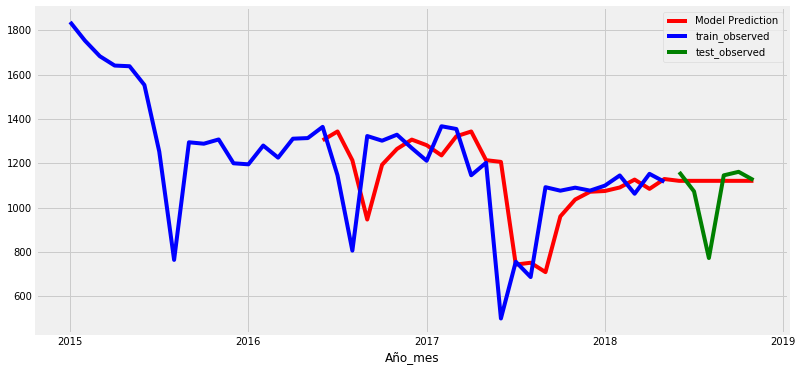

In [387]:
plt.figure(figsize=(12,6))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Prediction')
train_aguilera_WE.plot(color = 'blue', label = 'train_observed')
test_aguilera_WE.plot(color = 'green', label = 'test_observed')
plt.legend()
plt.show()

In [388]:
# Computation of the predicted values

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_forecasted

2018-06-30    1120.738667
2018-07-31    1120.738667
2018-08-31    1120.738667
2018-09-30    1120.738667
2018-10-31    1120.738667
2018-11-30    1120.738667
Freq: M, dtype: float64

In [389]:
# Computation of the test values

y_truth = test_aguilera_WE['2018-06-30':'2018-11-30']
y_truth

Año_mes
2018-06-30    1160.339706
2018-07-31    1073.117284
2018-08-31     772.188599
2018-09-30    1145.538009
2018-10-31    1161.447556
2018-11-30    1124.217157
Freq: M, Name: intensidad, dtype: float64

In [390]:
# Computation of MSE and RMSE
y_forecasted = model.predict('2018-06-30','2018-11-30')
y_truth = test_aguilera_WE['2018-06-30':'2018-11-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 21267.92
The Root Mean Squared Error of our forecasts is 145.84


## Applying the model

In [391]:
mod = sm.tsa.statespace.SARIMAX(series_aguilera_WE_before_MC,
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 0, 12))
model = mod.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             intensidad   No. Observations:                   47
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -310.298
Date:                Thu, 16 May 2019   AIC                            624.596
Time:                        00:34:46   BIC                            628.254
Sample:                    01-31-2015   HQIC                           625.966
                         - 11-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3878      0.110     -3.514      0.000      -0.604      -0.172
sigma2      4.231e+04   5787.463      7.310      0.000     3.1e+04    5.36e+04
Ljung-Box (Q):                       40.54   Jarque-

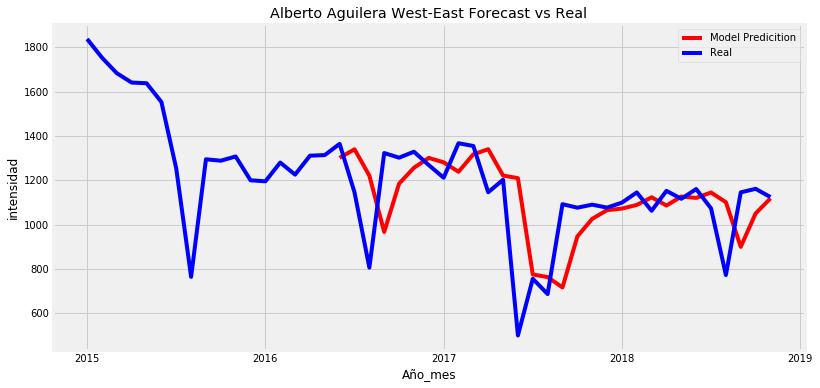

In [392]:
plt.figure(figsize=(12,6))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Predicition')
observed = series_aguilera_WE_before_MC.plot(color = 'blue', label = 'Real')

plt.title('Alberto Aguilera West-East Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

### Forecasting vs Reality Madrid Central months

In [393]:
# Now we do a time series with the months with Madrid Central to compare the prediction of the model vs the real data

aguilera_WE_only_MC = aguilera_WE_only_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
aguilera_WE_only_MC = aguilera_WE_only_MC.set_index(aguilera_WE_only_MC['Año_mes'])
aguilera_WE_only_MC.index = pd.to_datetime(aguilera_WE_only_MC.index)
series_aguilera_WE_only_MC = aguilera_WE_only_MC['intensidad'].resample('M').mean()

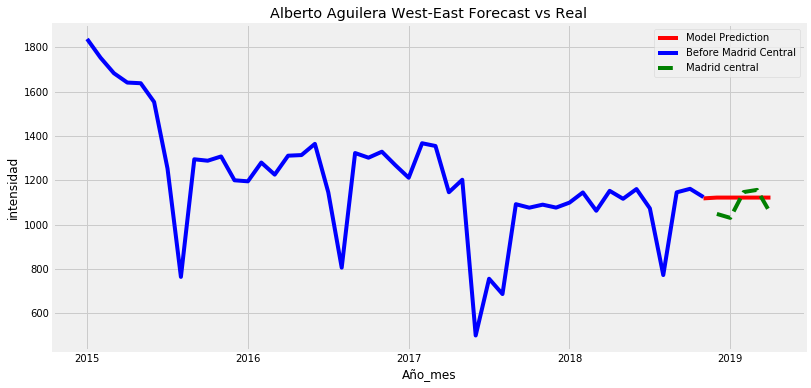

In [394]:
plt.figure(figsize=(12,6))
forecast = model.predict('2018-11-30','2019-04-30').plot(color = 'red', label='Model Prediction')
series_aguilera_WE_before_MC.plot(color = 'blue', label='Before Madrid Central')
series_aguilera_WE_only_MC.plot(linestyle='dashed', color = 'green', label = 'Madrid central')

plt.title('Alberto Aguilera West-East Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

#### We predicted a more balanced situation but the first months of Madrid Central were a bit lower than expected being finally a bit higher than our predictions but falling again

### Let's see numerical values

In [395]:
# Comparing the forecasted vs real on December 2018 and see the differences

y_forecasted_Dec18 = model.predict('2018-12-31')
y_truth_Dec18 = series_aguilera_WE_only_MC['2018-12-31']
y_forecasted_Dec18, y_truth_Dec18
print('On December it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Dec18, y_truth_Dec18))

On December it was expected an average of 1121 intensity and the result was 1048


In [396]:
# Here I compare the results of all the months of December of my dataset
# General trend of traffic intensity reduction

y_truth_Dec15 = series_aguilera_WE_before_MC['2015-12-31']
y_truth_Dec16 = series_aguilera_WE_before_MC['2016-12-31']
y_truth_Dec17 = series_aguilera_WE_before_MC['2017-12-31']
y_truth_Dec18 = series_aguilera_WE_only_MC['2018-12-31']

y_truth_Dec15, y_truth_Dec16, y_truth_Dec17, y_truth_Dec18

(1199.9888727624577,
 1268.5246679316888,
 1076.6362666666666,
 1048.1826375711576)

In [397]:
# Comparing the forecasted vs real on January 2019 and see the differences

y_forecasted_Jan19 = model.predict('2019-01-31')
y_truth_Jan19 = series_aguilera_WE_only_MC['2019-01-31']
y_forecasted_Jan19, y_truth_Jan19
print('On January it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Jan19, y_truth_Jan19))

On January it was expected an average of 1121 intensity and the result was 1030


In [398]:
# Here I compare the results of all the months of January of my dataset
# Historically the intensity has follow a decreasing trend

y_truth_Jan16 = series_aguilera_WE_before_MC['2016-01-31']
y_truth_Jan17 = series_aguilera_WE_before_MC['2017-01-31']
y_truth_Jan18 = series_aguilera_WE_before_MC['2018-01-31']
y_truth_Jan19 = series_aguilera_WE_only_MC['2019-01-31']

y_truth_Jan16, y_truth_Jan17, y_truth_Jan18, y_truth_Jan19

(1195.3126185958254,
 1211.4833965844402,
 1099.1670678863745,
 1030.3178368121442)

In [399]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_Feb19 = model.predict('2019-02-28')
y_truth_Feb19 = series_aguilera_WE_only_MC['2019-02-28']
y_forecasted_Feb19, y_truth_Feb19
print('On February it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Feb19, y_truth_Feb19))

On February it was expected an average of 1121 intensity and the result was 1146


In [400]:
# Here I compare the results of all the months of February of my dataset
# Big changes in the past and more balanced results last 2 years observations

y_truth_Feb15 = series_aguilera_WE_before_MC['2015-02-28']
y_truth_Feb16 = series_aguilera_WE_before_MC['2016-02-29']
y_truth_Feb17 = series_aguilera_WE_before_MC['2017-02-28']
y_truth_Feb18 = series_aguilera_WE_before_MC['2018-02-28']
y_truth_Feb19 = series_aguilera_WE_only_MC['2019-02-28']

y_truth_Feb15, y_truth_Feb16, y_truth_Feb17, y_truth_Feb18, y_truth_Feb19

(1753.496272630458,
 1280.048717948718,
 1367.1622899159663,
 1145.0571126388154,
 1146.857668067227)

In [401]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_March19 = model.predict('2019-03-31')
y_truth_March19 = series_aguilera_WE_only_MC['2019-03-31']
y_forecasted_March19, y_truth_March19
print('On March it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_March19, y_truth_March19))

On March it was expected an average of 1121 intensity and the result was 1156


In [402]:
# Here I compare the results of all the months of March of my dataset
# Genral Up&down trend with increase last observation

y_truth_March15 = series_aguilera_WE_before_MC['2015-03-31']
y_truth_March16 = series_aguilera_WE_before_MC['2016-03-31']
y_truth_March17 = series_aguilera_WE_before_MC['2017-03-31']
y_truth_March18 = series_aguilera_WE_before_MC['2018-03-31']
y_truth_March19 = series_aguilera_WE_only_MC['2019-03-31']

y_truth_March15, y_truth_March16, y_truth_March17, y_truth_March18, y_truth_March19

(1683.2719506407213,
 1225.5056294779938,
 1354.7930542340628,
 1062.4545019157088,
 1156.6446991404011)

In [403]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_Apr19 = model.predict('2019-04-30')
y_truth_Apr19 = series_aguilera_WE_only_MC['2019-04-30']
y_forecasted_Apr19, y_truth_Apr19
print('On April it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Apr19, y_truth_Apr19))

On April it was expected an average of 1121 intensity and the result was 1051


In [404]:
# Here I compare the results of all the months of March of my dataset
# General slowing down with a big drop this year

y_truth_Apr15 = series_aguilera_WE_before_MC['2015-04-30']
y_truth_Apr16 = series_aguilera_WE_before_MC['2016-04-30']
y_truth_Apr17 = series_aguilera_WE_before_MC['2017-04-30']
y_truth_Apr18 = series_aguilera_WE_before_MC['2018-04-30']
y_truth_Apr19 = series_aguilera_WE_only_MC['2019-04-30']

y_truth_Apr15, y_truth_Apr16, y_truth_Apr17, y_truth_Apr18, y_truth_Apr19

(1641.078055964654,
 1310.99468892261,
 1145.935739001483,
 1152.283464566929,
 1051.3776188042923)

## Focus on GRAN VIA DE SAN FRANCISCO North-South

In [405]:
# Split the information of each devices in:
    # Full dataset
    # Observations before Madrid Central (with the suffix "before_MC")
    # Observations since the beggining of Madrid Central (with the suffix "only_MC")
gvsanfran_NS = final_data[final_data['id'] == 3478]
gvsanfran_NS_before_MC = data_before_MC[data_before_MC['id'] == 3478]
gvsanfran_NS_only_MC = data_only_MC[data_only_MC['id'] == 3478]

In [406]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

gvsanfran_NS_before_MC = gvsanfran_NS_before_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
gvsanfran_NS_before_MC = gvsanfran_NS_before_MC.set_index(gvsanfran_NS_before_MC['Año_mes'])
gvsanfran_NS_before_MC.index = pd.to_datetime(gvsanfran_NS_before_MC.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_gvsanfran_NS_before_MC = gvsanfran_NS_before_MC['intensidad'].resample('M').mean()

Text(0.5, 1.0, 'Gran Via de San Francisco el Grande North-South')

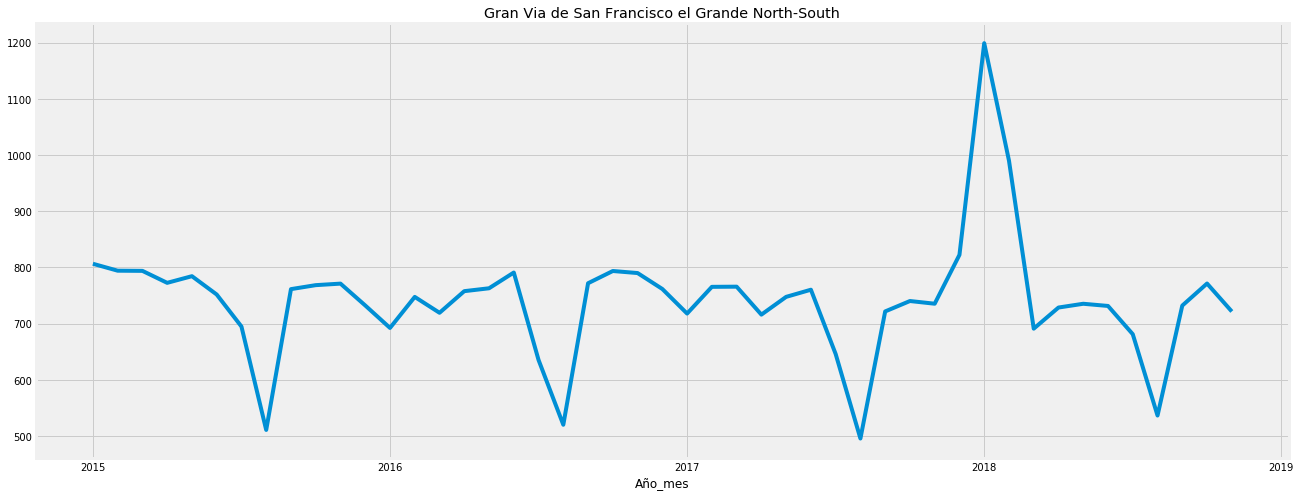

In [407]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_gvsanfran_NS_before_MC.plot()
plt.title('Gran Via de San Francisco el Grande North-South')

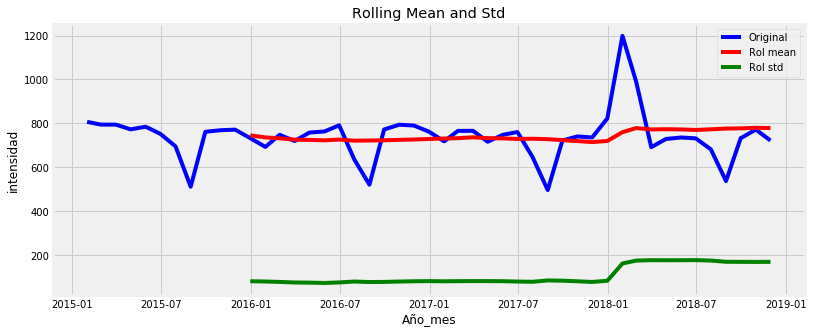

In [408]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_gvsanfran_NS = series_gvsanfran_NS_before_MC.rolling(12).mean()
rolstd_gvsanfran_NS = series_gvsanfran_NS_before_MC.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_gvsanfran_NS_before_MC, label = 'Original', color = 'blue')
plt.plot(rolmean_gvsanfran_NS, label = 'Rol mean', color = 'red')
plt.plot(rolstd_gvsanfran_NS, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

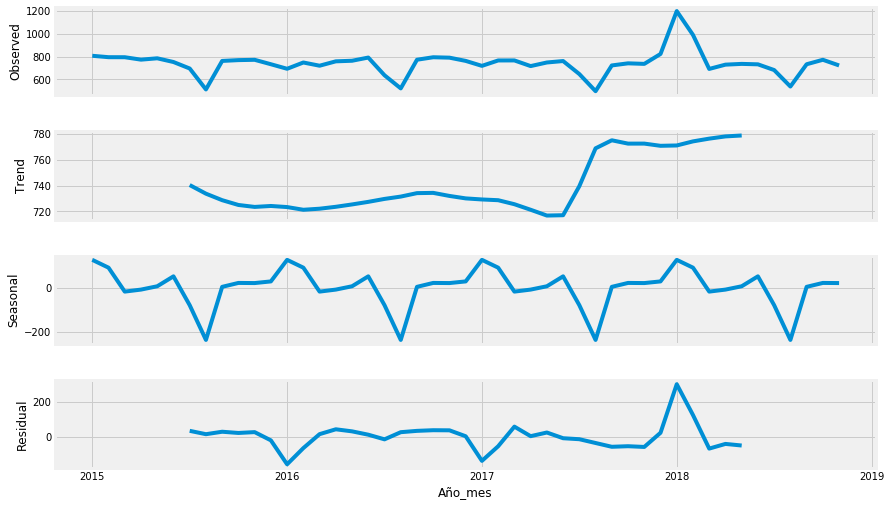

In [409]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_gvsanfran_NS_before_MC, model = 'additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [410]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_gvsanfran_NS_before_MC, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))

# Stationary since the p-value < 0.05

Test statistic: -4.80161034252456
p-value: 5.400147690057677e-05
Lag: 1
Number of observations: 45
Critical Value (1%) = -3.584828853223594
Critical Value (5%) = -2.9282991495198907
Critical Value (10%) = -2.6023438271604937


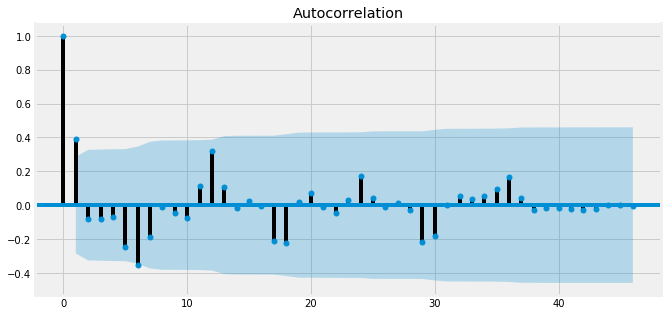

In [412]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_gvsanfran_NS_before_MC)
fig.set_size_inches(10,5)

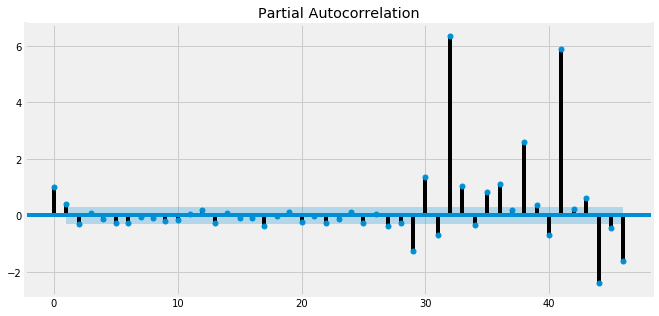

In [413]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_gvsanfran_NS_before_MC)
fig.set_size_inches(10,5)

### Now it's time to build the model

In [414]:
len(series_gvsanfran_NS_before_MC)

47

In [415]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_gvsanfran_NS = series_gvsanfran_NS_before_MC.loc['2015-01-31':'2018-05-31']
test_gvsanfran_NS = series_gvsanfran_NS_before_MC.loc['2018-06-01':'2018-11-30']

In [416]:
len(train_gvsanfran_NS), len(test_gvsanfran_NS)

(41, 6)

In [417]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_gvsanfran_NS, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2018-06-30','2018-11-30')
            y_truth = test_gvsanfran_NS['2018-06-30':'2018-11-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:661.8443733028753 - p-values:sigma2    0.310537
dtype: float64
The Mean Squared Error of our forecasts is 489759.52
The Root Mean Squared Error of our forecasts is 699.83
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:355.5871430201929 - p-values:sigma2    3.525638e-23
dtype: float64
The Mean Squared Error of our forecasts is 836.26
The Root Mean Squared Error of our forecasts is 28.92
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:357.5862160574358 - p-values:ar.S.L12    0.996123
sigma2      0.000010
dtype: float64
The Mean Squared Error of our forecasts is 839.76
The Root Mean Squared Error of our forecasts is 28.98
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:617.2567522344184 - p-values:ma.L1     3.375971e-09
sigma2    6.336600e-02
dtype: float64
The Mean Squared Error of our forecasts is 413132.21
The Root Mean Squared Error of our forecasts is 642.75
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:350.2493332652662 - p-values:ma.L1     1.600190e-01
sigma2    2.929857e-08
dtype: flo

In [424]:
# The model selectede is SARIMAX(0, 1, 0)x(1, 0, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_gvsanfran_NS,
                                order=(0, 1, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   41
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -245.674
Date:                            Thu, 16 May 2019   AIC                            495.348
Time:                                    00:39:31   BIC                            498.726
Sample:                                01-31-2015   HQIC                           496.570
                                     - 05-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5148      0.197      2.613      0.009       0.129       0.901
sigma2      1.153e+04   1439.138   

In [425]:
# let's have a look at the residuals in order to test their distribution and correlation

residuos = model.resid.values
residuos

array([ 8.06517345e+02, -1.23272193e+01, -3.02608253e-01, -2.13158782e+01,
        1.18475722e+01, -3.25847747e+01, -5.69888903e+01, -1.84014378e+02,
        2.50553643e+02,  7.08008762e+00,  2.71919882e+00, -3.88608770e+01,
       -4.63847800e+01,  6.15351085e+01, -2.80888535e+01,  4.94546579e+01,
       -9.80551232e-01,  4.47893206e+01, -1.26246639e+02, -2.05299053e+01,
        1.22836846e+02,  1.81012026e+01, -5.04180055e+00, -8.36532140e+00,
       -2.31111920e+01,  1.91121252e+01,  1.48460983e+01, -6.95334179e+01,
        2.89488759e+01, -1.70401485e+00, -3.43000482e+01, -9.10310565e+01,
        9.64981397e+01,  7.32986351e+00, -2.92995018e+00,  1.01570820e+02,
        3.99037190e+02, -2.33372907e+02, -2.99139485e+02,  6.31821243e+01,
       -9.55509117e+00])

In [426]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.727 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=3.9843437596804847, critical_values=array([0.532, 0.606, 0.727, 0.848, 1.009]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [427]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([0.12734979, 1.32429372, 1.3746108 , 1.44846827, 1.70050104,
        1.94223731, 2.27804491, 3.84458393, 3.85867555, 3.92937687,
        3.92937706, 3.93451118]),
 array([0.72119585, 0.51574292, 0.71149674, 0.83572876, 0.88883663,
        0.92493358, 0.94286376, 0.87086625, 0.92046535, 0.95047667,
        0.9719375 , 0.98458931]),
 array([0.11846492, 1.20406523, 1.24853149, 1.31208326, 1.52308744,
        1.71984952, 1.98537181, 3.18759943, 3.19808622, 3.24905693,
        3.24905707, 3.25251962]),
 array([0.73070541, 0.54769725, 0.74138951, 0.85932212, 0.91039025,
        0.94357858, 0.96064556, 0.92203877, 0.95592073, 0.97494047,
        0.98700797, 0.99348337]))

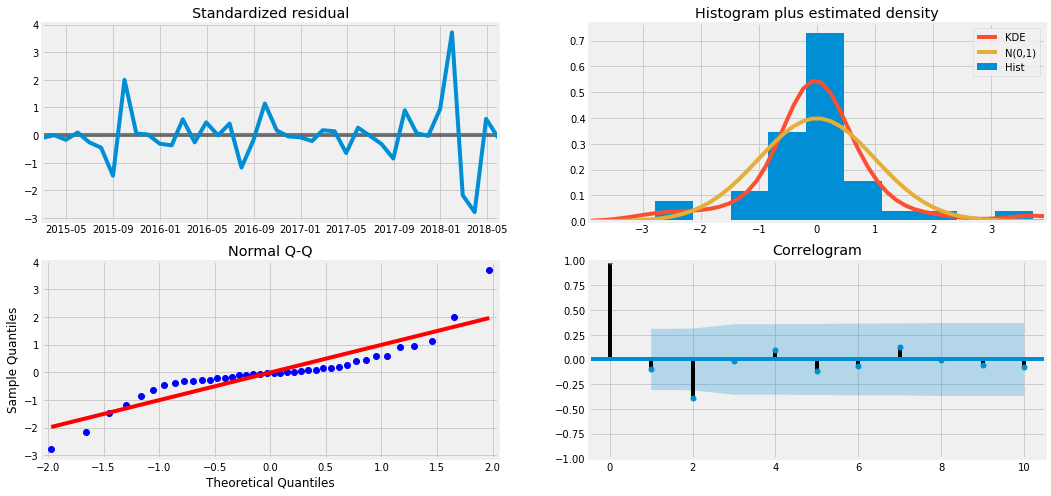

In [428]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

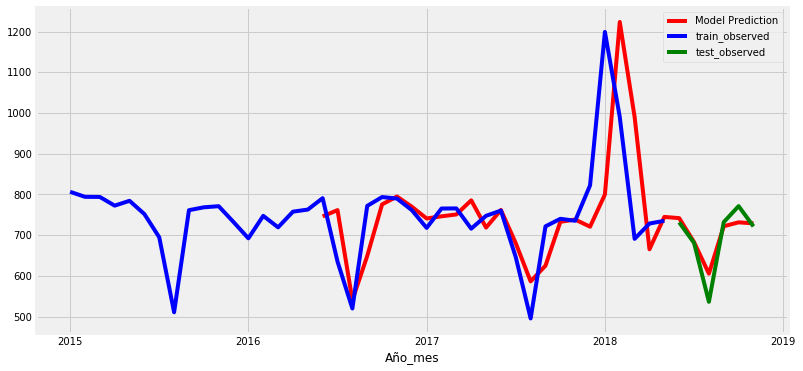

In [429]:
plt.figure(figsize=(12,6))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Prediction')
train_gvsanfran_NS.plot(color = 'blue', label = 'train_observed')
test_gvsanfran_NS.plot(color = 'green', label = 'test_observed')
plt.legend()
plt.show()

In [430]:
# Computation of the predicted values

y_forecasted = model.predict('2018-06-30','2018-11-30')
y_forecasted

2018-06-30    741.891342
2018-07-31    683.003957
2018-08-31    605.598811
2018-09-30    722.007318
2018-10-31    731.543371
2018-11-30    729.069934
Freq: M, dtype: float64

In [431]:
# Computation of the test values

y_truth = test_gvsanfran_NS['2018-06-30':'2018-11-30']
y_truth

Año_mes
2018-06-30    731.453464
2018-07-31    681.202754
2018-08-31    536.483103
2018-09-30    732.091966
2018-10-31    771.361682
2018-11-30    721.612205
Freq: M, Name: intensidad, dtype: float64

In [432]:
# Computation of MSE and RMSE
y_forecasted = model.predict('2018-06-30','2018-11-30')
y_truth = test_gvsanfran_NS['2018-06-30':'2018-11-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1105.33
The Root Mean Squared Error of our forecasts is 33.25


## Applying the model

In [433]:
mod = sm.tsa.statespace.SARIMAX(series_gvsanfran_NS_before_MC,
                                order=(0, 1, 0),
                                seasonal_order=(1, 0, 0, 12))
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   47
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -279.576
Date:                            Thu, 16 May 2019   AIC                            563.153
Time:                                    00:39:52   BIC                            566.810
Sample:                                01-31-2015   HQIC                           564.523
                                     - 11-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5924      0.167      3.538      0.000       0.264       0.921
sigma2      9937.3728   1056.449   

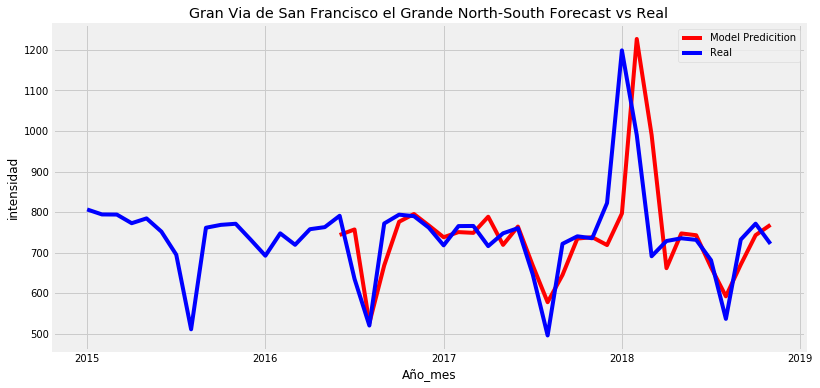

In [434]:
plt.figure(figsize=(12,6))
forecast = model.predict('2016-06-30','2018-11-30').plot(color = 'red', label = 'Model Predicition')
observed = series_gvsanfran_NS_before_MC.plot(color = 'blue', label = 'Real')

plt.title('Gran Via de San Francisco el Grande North-South Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

### Forecasting vs Reality Madrid Central months

In [435]:
# Now we do a time series with the months with Madrid Central to compare the prediction of the model vs the real data

gvsanfran_NS_only_MC = gvsanfran_NS_only_MC.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
gvsanfran_NS_only_MC = gvsanfran_NS_only_MC.set_index(gvsanfran_NS_only_MC['Año_mes'])
gvsanfran_NS_only_MC.index = pd.to_datetime(gvsanfran_NS_only_MC.index)
series_gvsanfran_NS_only_MC = gvsanfran_NS_only_MC['intensidad'].resample('M').mean()

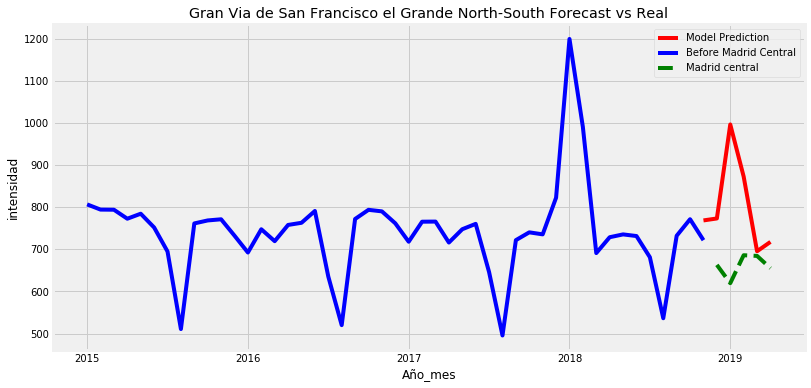

In [436]:
plt.figure(figsize=(12,6))
forecast = model.predict('2018-11-30','2019-04-30').plot(color = 'red', label='Model Prediction')
series_gvsanfran_NS_before_MC.plot(color = 'blue', label='Before Madrid Central')
series_gvsanfran_NS_only_MC.plot(linestyle='dashed', color = 'green', label = 'Madrid central')

plt.title('Gran Via de San Francisco el Grande North-South Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

#### We predicted a high increase since the model is probably impacted by last year observations but the reality was totally the opposite. It is probably one of the most impacted areas

### Let's see numerical values

In [437]:
# Comparing the forecasted vs real on December 2018 and see the differences

y_forecasted_Dec18 = model.predict('2018-12-31')
y_truth_Dec18 = series_gvsanfran_NS_only_MC['2018-12-31']
y_forecasted_Dec18, y_truth_Dec18
print('On December it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Dec18, y_truth_Dec18))

On December it was expected an average of 773 intensity and the result was 663


In [438]:
# Here I compare the results of all the months of December of my dataset
# Trend increasing historically and big drop this year

y_truth_Dec15 = series_gvsanfran_NS_before_MC['2015-12-31']
y_truth_Dec16 = series_gvsanfran_NS_before_MC['2016-12-31']
y_truth_Dec17 = series_gvsanfran_NS_before_MC['2017-12-31']
y_truth_Dec18 = series_gvsanfran_NS_only_MC['2018-12-31']

y_truth_Dec15, y_truth_Dec16, y_truth_Dec17, y_truth_Dec18

(732.323221180364, 761.6209677419355, 822.399251737039, 663.0322580645161)

In [439]:
# Comparing the forecasted vs real on January 2019 and see the differences

y_forecasted_Jan19 = model.predict('2019-01-31')
y_truth_Jan19 = series_gvsanfran_NS_only_MC['2019-01-31']
y_forecasted_Jan19, y_truth_Jan19
print('On January it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Jan19, y_truth_Jan19))

On January it was expected an average of 996 intensity and the result was 619


In [440]:
# Here I compare the results of all the months of January of my dataset
# Trend increasing historically and big drop this year

y_truth_Jan16 = series_gvsanfran_NS_before_MC['2016-01-31']
y_truth_Jan17 = series_gvsanfran_NS_before_MC['2017-01-31']
y_truth_Jan18 = series_gvsanfran_NS_before_MC['2018-01-31']
y_truth_Jan19 = series_gvsanfran_NS_only_MC['2019-01-31']

y_truth_Jan16, y_truth_Jan17, y_truth_Jan18, y_truth_Jan19

(692.3509272467903, 717.9326375711574, 1198.9463437796771, 619.602948169282)

In [441]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_Feb19 = model.predict('2019-02-28')
y_truth_Feb19 = series_gvsanfran_NS_only_MC['2019-02-28']
y_forecasted_Feb19, y_truth_Feb19
print('On February it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Feb19, y_truth_Feb19))

On February it was expected an average of 872 intensity and the result was 685


In [442]:
# Here I compare the results of all the months of February of my dataset
# # Trend increasing historically and big drop this year

y_truth_Feb15 = series_gvsanfran_NS_before_MC['2015-02-28']
y_truth_Feb16 = series_gvsanfran_NS_before_MC['2016-02-29']
y_truth_Feb17 = series_gvsanfran_NS_before_MC['2017-02-28']
y_truth_Feb18 = series_gvsanfran_NS_before_MC['2018-02-28']
y_truth_Feb19 = series_gvsanfran_NS_only_MC['2019-02-28']

y_truth_Feb15, y_truth_Feb16, y_truth_Feb17, y_truth_Feb18, y_truth_Feb19

(794.1901260504202,
 747.5401678657074,
 765.4553571428571,
 990.0374208405296,
 685.9374342797056)

In [443]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_March19 = model.predict('2019-03-31')
y_truth_March19 = series_gvsanfran_NS_only_MC['2019-03-31']
y_forecasted_March19, y_truth_March19
print('On March it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_March19, y_truth_March19))

On March it was expected an average of 695 intensity and the result was 684


In [444]:
# Here I compare the results of all the months of March of my dataset
# Up and down trend

y_truth_March15 = series_gvsanfran_NS_before_MC['2015-03-31']
y_truth_March16 = series_gvsanfran_NS_before_MC['2016-03-31']
y_truth_March17 = series_gvsanfran_NS_before_MC['2017-03-31']
y_truth_March18 = series_gvsanfran_NS_before_MC['2018-03-31']
y_truth_March19 = series_gvsanfran_NS_only_MC['2019-03-31']

y_truth_March15, y_truth_March16, y_truth_March17, y_truth_March18, y_truth_March19

(793.8875177978168,
 719.295536172396,
 765.7615421227987,
 691.0555555555555,
 684.3022922636103)

In [445]:
# Comparing the forecasted vs real on February 2019 and see the differences

y_forecasted_Apr19 = model.predict('2019-04-30')
y_truth_Apr19 = series_gvsanfran_NS_only_MC['2019-04-30']
y_forecasted_Apr19, y_truth_Apr19
print('On April it was expected an average of %.d intensity and the result was %.d' % (y_forecasted_Apr19, y_truth_Apr19))

On April it was expected an average of 717 intensity and the result was 655


In [446]:
# Here I compare the results of all the months of March of my dataset
# # Trend decreasing historically (except one year) and big drop this year

y_truth_Apr15 = series_gvsanfran_NS_before_MC['2015-04-30']
y_truth_Apr16 = series_gvsanfran_NS_before_MC['2016-04-30']
y_truth_Apr17 = series_gvsanfran_NS_before_MC['2017-04-30']
y_truth_Apr18 = series_gvsanfran_NS_before_MC['2018-04-30']
y_truth_Apr19 = series_gvsanfran_NS_only_MC['2019-04-30']

y_truth_Apr15, y_truth_Apr16, y_truth_Apr17, y_truth_Apr18, y_truth_Apr19

(772.5716395864106,
 757.7770992366412,
 716.0378564405113,
 728.6406712734453,
 655.1698576337751)

#### Move to next notebook number 4